In [1]:
import sys
sys.path.append('../')
sys.path.append('../2DKS')
import KS2D
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn, join, unique
from astropy.table import vstack

from tqdm import tqdm
import pandas as pd
import WD_models

In [2]:
from astropy.table import Table, join_skycoord
from astropy.coordinates import SkyCoord
from astropy import table
import astropy.units as u

c0 = Table.read('data/base_catalog.fits')
nug = fits.open('data/03_wd_rv.fits')
c1 = Table(nug[1].data)
nug = fits.open('data/02_photometry.fits')
c2 = Table(nug[1].data)
nug = fits.open('data/04_ms_rv.fits')
c3 = Table(nug[1].data)

print(len(c3))


catalog = join(c1, c2, keys = 'wd_source_id', join_type = 'inner')
catalog = unique(join(join(join(c0, c1, keys = 'wd_source_id'), c2, keys = 'wd_source_id'), c3, keys='ms_source_id'), keys = 'wd_source_id')

609


In [3]:
nt_wd = np.all([c1['wd_rv_from'] != 'falcon'], axis = 0)
print(len(c1[nt_wd]))

392


In [4]:
catalog['g_redshift'] = catalog['wd_rv'] - catalog['radial_velocity']
catalog['eg_redshift'] = np.sqrt(catalog['wd_e_rv']**2 + catalog['radial_velocity_error']**2)
print(len(catalog))

395


In [5]:
test = catalog[catalog['R_chance_align'] < 0.01]
print(len(test))

304


In [6]:
a=0
b=0
c=0
d=0
e=0
f=0
g=0
h=0

for i in range(len(test)):
    if test['wd_rv_from'][i] == 'sdss4' and test['ms_rv_from'][i] == 'gaia':
        a +=1
    elif test['wd_rv_from'][i] == 'sdss4' and test['ms_rv_from'][i] == 'sdss4':
        b+=1
    elif test['wd_rv_from'][i] == 'sdss4' and test['ms_rv_from'][i] == 'sdss5':
        f+=1
    elif test['wd_rv_from'][i] == 'sdss5' and test['ms_rv_from'][i] == 'gaia':
        c += 1
    elif test['wd_rv_from'][i] == 'sdss5' and test['ms_rv_from'][i] == 'sdss4':
        d +=1
    elif test['wd_rv_from'][i] == 'sdss5' and test['ms_rv_from'][i] == 'sdss5':
        e += 1
    elif test['wd_rv_from'][i] == 'falcon':
        g += 1
    elif test['ms_rv_from'][i] == 'apo':
        h+=1

In [7]:
print('wd sdss4 / ms gaia: {}'.format(a))
print('wd sdss4 / ms sdss4: {}'.format(b))
print('wd sdss4 / ms sdss5: {}'.format(f))
print('wd sdss5 / ms gaia: {}'.format(c))
print('wd sdss5 / ms sdss4: {}'.format(d))
print('wd sdss5 / ms sdss5: {}'.format(e))
print('falcon: {}'.format(g))
print('apo: {}'.format(h))

wd sdss4 / ms gaia: 128
wd sdss4 / ms sdss4: 5
wd sdss4 / ms sdss5: 36
wd sdss5 / ms gaia: 86
wd sdss5 / ms sdss4: 0
wd sdss5 / ms sdss5: 39
falcon: 6
apo: 4


In [8]:
len(test[test['wd_instrument'] == 'SDSS'])

79

In [9]:
#from astroquery.sdss import SDSS
#from astroquery.gaia import Gaia
#
#Gaia.ROW_LIMIT = -1
#
#ADQL_CODE1 = """SELECT sdss.original_ext_source_id as bestObjID, gaia.source_id as wd_source_id 
#    FROM gaiadr3.gaia_source as gaia
#    JOIN gaiaedr3.sdssdr13_best_neighbour as sdss
#    ON gaia.source_id = sdss.source_id      
#    WHERE gaia.source_id in {}""".format(tuple(test['wd_source_id']))
#ids = Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results()
#
#query = """select sp.bestObjID, sp.survey
#            from dbo.SpecObjAll as sp
#            where sp.bestObjID in {}""".format(tuple(ids['bestObjID']))
#f = SDSS.query_sql(query)
#
#f = join(ids, f, keys='bestObjID')

In [10]:
#test[test['wd_source_id'] == 5177859052746654208]

In [11]:
#f = unique(f, keys = 'wd_source_id')

In [12]:
#test = join(test, f, keys='wd_source_id', join_type='outer')

In [13]:
#et(test[test['wd_rv_from'] == 'sdss4']['wd_instrument'])

In [14]:
#print(len(test[np.all([test['wd_rv_from'] == 'sdss4', test['wd_instrument'] == 'SDSS'], axis = 0)]))

In [15]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_60034/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_60034/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_60034/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


In [16]:
catalog[catalog['ms_rv_from'] == 'apo']['snr'] = [999, 999, 999, 999]

In [17]:
''' GENERATE MASK FROM FLAGS '''

logg_interp = WD_models.interp_xy_z_func(x = font_model['color'], y = font_model['Mag'],\
                                                z = font_model['logg'], interp_type = 'linear')

catalog['ms_bp_rp'] = (catalog['ms_phot_bp_mean_mag'] + 5 * np.log10(catalog['ms_parallax'])) - (catalog['ms_phot_rp_mean_mag'] + 5 * np.log10(catalog['ms_parallax']))
catalog['interp_logg'] = logg_interp(catalog['wd_bp_rp'], catalog['wd_m_g'])




gaia = np.all([catalog['ms_gaia'] == 1], axis = 0)
falcon = np.all([catalog['wd_rv_from'] == 'falcon'], axis = 0)

rechi = np.all([catalog['wd_rechi'] < 5], axis = 0)
wd_redchi = np.all([catalog['redchi'] < 5], axis = 0)
ms_redchi = np.all([catalog['ms_redchi'] < 1.5], axis = 0)

binary = np.all([catalog['radius'] < 0.0155], axis = 0) 
m_dwarf = np.all([catalog['ms_bp_rp'] < 2], axis = 0)

snr = np.all([catalog['snr'] > 15], axis = 0)
hig_snr = np.all([catalog['snr'] > 30], axis = 0)

chance = np.all([catalog['R_chance_align'] < 0.01], axis = 0)
nans = ~np.isnan(catalog['radial_velocity'])

not_da = np.ones(len(catalog))
for i in range(len(not_da)):
    if catalog['wd_catalog_id'][i] in [143.0, 345]:
        not_da[i] = 0

#corv_err = np.all([catalog['eg_redshift'] < 100], axis = 0)
    
nto = np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, binary], axis = 0)

#mask =  np.any([catalog['ms_rv_from'] == 'apo', np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, binary], axis = 0)], axis = 0)
#hrmask =  np.any([catalog['ms_rv_from'] == 'apo', np.all([ms_redchi, wd_redchi, rechi, hig_snr, chance, not_da, binary], axis = 0)], axis = 0)

mask =  np.any([catalog['ms_rv_from'] == 'apo', np.all([ms_redchi, wd_redchi, rechi, snr, chance, binary, nans], axis = 0)], axis = 0)
hrmask =  np.any([catalog['ms_rv_from'] == 'apo', np.all([ms_redchi, wd_redchi, rechi, hig_snr, chance, binary, nans], axis = 0)], axis = 0)


for i in range(len(mask)):
    if (catalog['wd_source_id'][i] == 3262517837340737152) or (catalog['wd_catalog_id'][i] in [306]) or (catalog['wd_catalog_id'][i] in [456]):
        mask[i] = False
        hrmask[i] = False

from_gaia = np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, gaia], axis = 0)
from_sdss= np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, ~gaia], axis = 0)
from_falcon= np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, falcon], axis = 0)

print(len(catalog[nto]))
print(len(catalog[mask]))

128
130


In [18]:
catalog[mask][catalog[mask]['pairdistance'] < 0.00111111]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [19]:
a=0
b=0
c=0
d=0
e=0
f=0
g=0
h=0

for i in range(len(catalog[mask])):
    if catalog[mask]['wd_rv_from'][i] == 'sdss4' and catalog[mask]['ms_rv_from'][i] == 'gaia':
        a +=1
    elif catalog[mask]['wd_rv_from'][i] == 'sdss4' and catalog[mask]['ms_rv_from'][i] == 'sdss4':
        b+=1
    elif catalog[mask]['wd_rv_from'][i] == 'sdss4' and catalog[mask]['ms_rv_from'][i] == 'sdss5':
        f+=1
    elif catalog[mask]['wd_rv_from'][i] == 'sdss5' and catalog[mask]['ms_rv_from'][i] == 'gaia':
        c += 1
    elif catalog[mask]['wd_rv_from'][i] == 'sdss5' and catalog[mask]['ms_rv_from'][i] == 'sdss4':
        d +=1
    elif catalog[mask]['wd_rv_from'][i] == 'sdss5' and catalog[mask]['ms_rv_from'][i] == 'sdss5':
        e += 1
    elif catalog[mask]['wd_rv_from'][i] == 'falcon':
        g += 1
    elif catalog[mask]['ms_rv_from'][i] == 'apo':
        h+=1

In [20]:
print('wd sdss4 / ms gaia: {}'.format(a))
print('wd sdss4 / ms sdss4: {}'.format(b))
print('wd sdss4 / ms sdss5: {}'.format(f))
print('wd sdss5 / ms gaia: {}'.format(c))
print('wd sdss5 / ms sdss4: {}'.format(d))
print('wd sdss5 / ms sdss5: {}'.format(e))
print('falcon: {}'.format(g))
print('apo: {}'.format(h))

wd sdss4 / ms gaia: 67
wd sdss4 / ms sdss4: 1
wd sdss4 / ms sdss5: 11
wd sdss5 / ms gaia: 32
wd sdss5 / ms sdss4: 0
wd sdss5 / ms sdss5: 10
falcon: 6
apo: 3


27


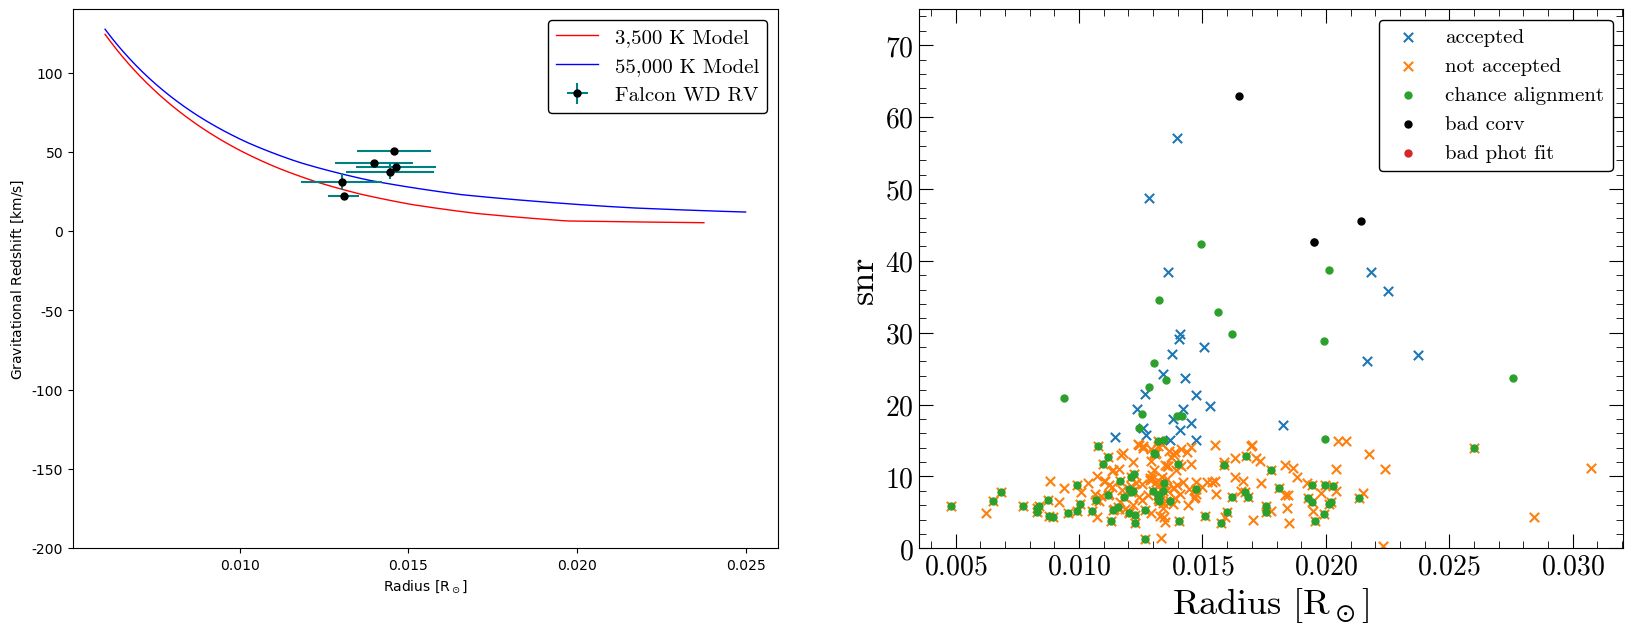

In [21]:
''' PLOTTING '''

plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

#for i in range(len(catalog['radius'][from_falcon])):
#    x = catalog['radius'][from_falcon][i]
#    y = catalog['g_redshift'][from_falcon][i]
# #   plt.plot(x, y, 'bo')
#    
#    #if (0.006 < x < 0.025) and (-50 < y < 120):
#    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f, %2.2f' % (catalog['wd_catalog_id_phot'][from_falcon][i], catalog['wd_catalog_id'][from_falcon][i])), fontsize=19)
    
# Data


plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr=catalog['eg_redshift'][from_falcon], fmt='o', 
             label = 'Falcon WD RV', color='black', ecolor = 'teal')
#plt.errorbar(catalog['radius'][from_sdss], catalog['g_redshift'][from_sdss], xerr = catalog['e_radius'][from_sdss], yerr=catalog['eg_redshift'][from_sdss], fmt='o', 
#             label = 'SDSS MS RV', color='red', ecolor = 'teal')

print(len(catalog['radius'][from_sdss]))

#plt.errorbar(catalog['radius'][catalog['wd_catalog_id'] == 49], catalog['g_redshift'][catalog['wd_catalog_id'] == 49],
#            xerr = catalog['e_radius'][catalog['wd_catalog_id'] == 49], yerr = catalog['eg_redshift'][catalog['wd_catalog_id'] == 49])

#plt.scatter(catalog['radius'][catalog['wd_catalog_id'] == 26], catalog['g_redshift'][catalog['wd_catalog_id'] == 26])


#refs = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
#ms_stuff = Table.read('data/ms_sdss4_wd_sdss4.fits')

#for i in range(len(c2)):
#    if (c2['wd_source_id'][i] in refs['wd_source_id']):
#        plt.axvline(x=c2['radius'][i], ls='--', c='red', lw=0.3)
#    elif (c2['wd_source_id'][i] in refs['wd_source_id']):
#        plt.axvline(x=c2['radius'][i], ls=':', c='green', lw=0.3)
#

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
plt.ylim(-200, 140)
plt.legend()

plt.subplot(1,2,2) 

#plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')


#plt.scatter(catalog['radius'], catalog['snr'], label='base')
plt.scatter(catalog['radius'][from_sdss], catalog['snr'][from_sdss], label='accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~snr], catalog['snr'][~snr], label='not accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~chance], catalog['snr'][~chance], label='chance alignment')
plt.scatter(catalog['radius'][~rechi], catalog['snr'][~rechi], label='bad corv', color = 'black')
plt.scatter(catalog['radius'][~wd_redchi], catalog['snr'][~wd_redchi], label='bad phot fit')

plt.ylim(0, 75)


#for i in range(len(catalog['radius'])):
#    x = catalog['radius'][i]
#    y = catalog['snr'][i]
#    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f' % (catalog['wd_catalog_id'][i])), fontsize=11)


plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'snr')
plt.legend()

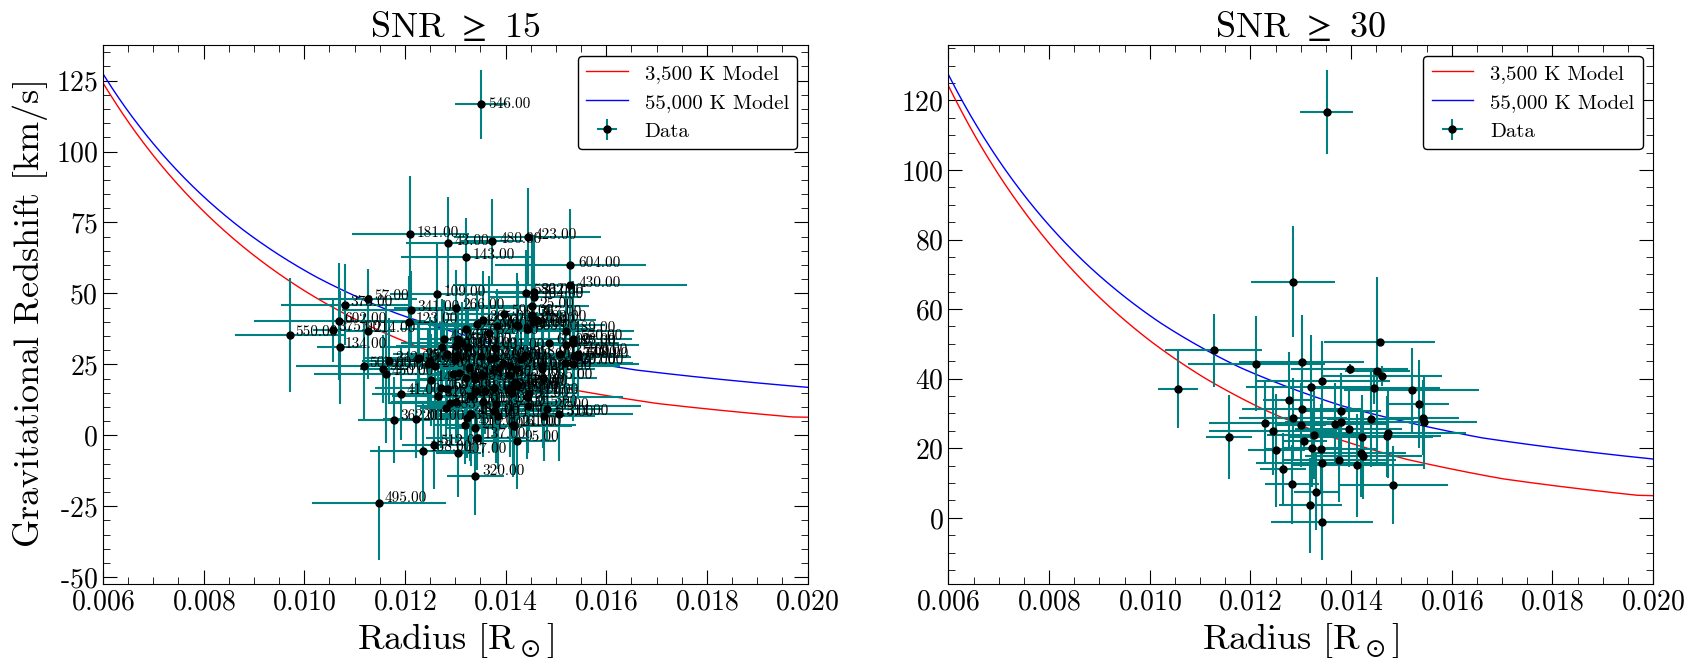

In [22]:
''' PLOTTING '''

fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

for i in range(len(catalog[mask]['radius'])):
    x = catalog[mask]['radius'][i]
    y = catalog[mask]['g_redshift'][i]
    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f' % (catalog['wd_catalog_id'][mask][i])), fontsize=11)


plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlim(0.006, 0.02)
#plt.ylim(-20, 130)

#plt.axvline(x=0.01)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 15', fontsize=26)
plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

#for i in range(len(catalog[hrmask]['radius'])):
#    x = catalog[hrmask]['radius'][i]
#    y = catalog[hrmask]['g_redshift'][i]
#    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f' % (catalog['wd_catalog_id'][hrmask][i])), fontsize=11)

plt.errorbar(catalog['radius'][hrmask], catalog['g_redshift'][hrmask], xerr = catalog['e_radius'][hrmask], yerr = catalog['eg_redshift'][hrmask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
plt.xlim(0.006, 0.02)
#plt.ylim(-20, 130)

plt.xlabel(r'Radius $[R_\odot]$')
#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 30', fontsize=26)
plt.legend()
#plt.colorbar()

plt.savefig('spectra/curve_withhighsnr.pdf')

In [23]:
catalog[catalog['wd_catalog_id'] == 546]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [24]:
catalog[catalog['wd_catalog_id'] == 456]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

22
3
6
99
22
3
6
99


/tmp/ipykernel_60034/1378563267.py:40: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(catalog['radius'][sdss_mask], catalog['g_redshift'][sdss_mask], xerr = catalog['e_radius'][sdss_mask], yerr = catalog['eg_redshift'][sdss_mask], fmt='o', label = 'MS SDSS + WD SDSS', color='black', ecolor = 'teal', marker = '^', ms = 5)
/tmp/ipykernel_60034/1378563267.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(catalog['radius'][apo_mask], catalog['g_redshift'][apo_mask], xerr = catalog['e_radius'][apo_mask], yerr = catalog['eg_redshift'][apo_mask], fmt='o', label = 'MS APO + WD SDSS', color='black', ecolor = 'teal', marker = 'd', ms = 5)
/tmp/ipykernel_60034/1378563267.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword

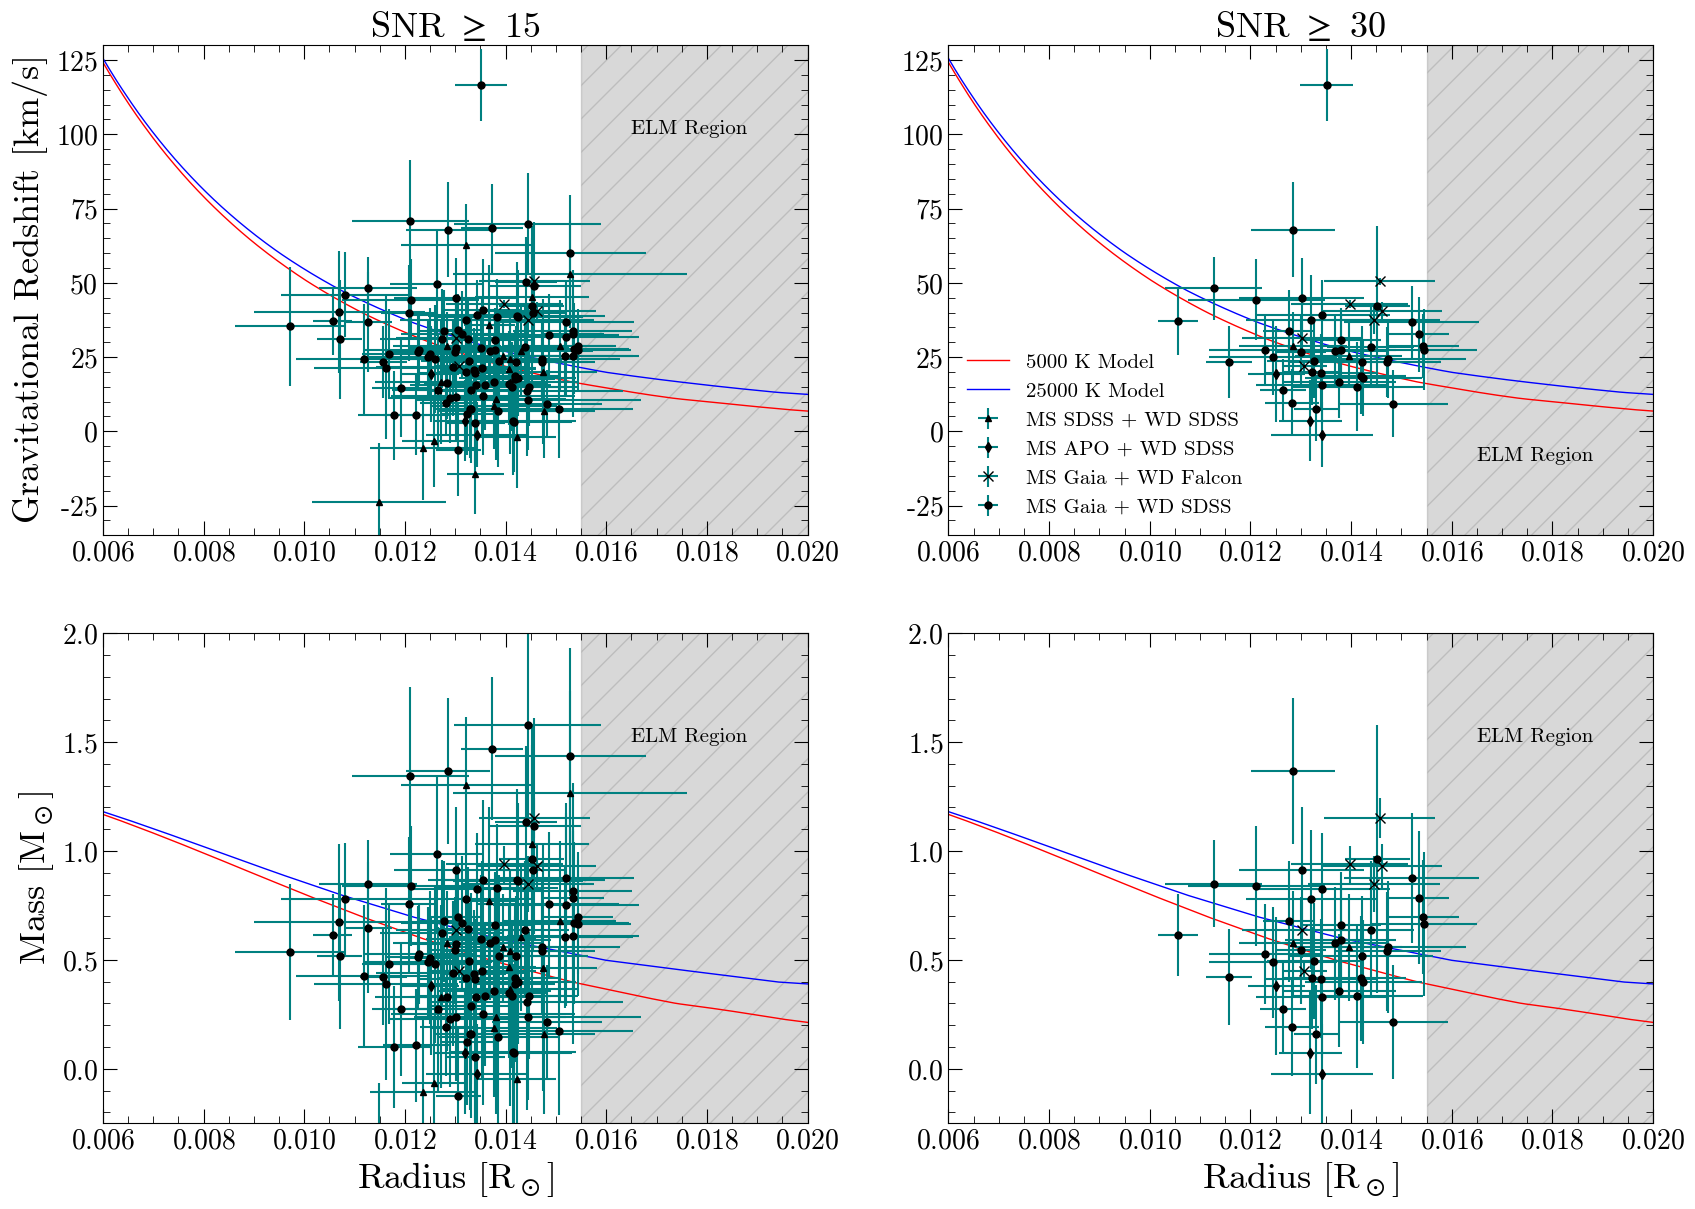

In [25]:
from matplotlib.ticker import MaxNLocator

vg_min, vg_max = -35, 130
rmin, rmax = 0.006, 0.02

''' PLOTTING '''

def vg_r_to_m(vg, r):
    return ((5.03e-31)*(2.06e-12)/(2.97e-27)) * (r * 2.998e5 * vg) / (6.674e-11)

def e_m(vg, r, e_vg, e_r):
    return np.sqrt((((5.03e-31)*(2.06e-12)/(2.97e-27)) * (r * 2.998e5) / (6.674e-11) * e_vg)**2 + (((5.03e-31)*(2.06e-12)/(2.97e-27)) * (vg * 2.998e5) / (6.674e-11) * e_r)**2 )

fig = plt.figure(figsize=(20,14))
plt.subplot(2,2,1) 
plt.style.use('./stefan.mplstyle')

"""
ONE
"""

theoretical_rvsc = rv_from_radius(rsuns, 5000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvsc, 'red', linestyle = '-', label = '5000 K Model', linewidth = 1)

theoretical_rvsh = rv_from_radius(rsuns, 25000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvsh, 'blue', label = '25000 K Model', linewidth = 1)

sdss_mask = np.all([catalog['ms_rv_from'] != 'gaia', catalog['ms_rv_from'] != 'apo', mask], axis = 0) 
apo_mask = np.all([catalog['ms_rv_from'] == 'apo', mask], axis = 0) 
falcon_mask = np.all([catalog['wd_rv_from'] == 'falcon', mask], axis = 0)
other = np.all([~sdss_mask, ~apo_mask, ~falcon_mask, mask], axis = 0)

print(sum(sdss_mask))
print(sum(apo_mask))
print(sum(falcon_mask))
print(sum(other))

# Data

plt.errorbar(catalog['radius'][sdss_mask], catalog['g_redshift'][sdss_mask], xerr = catalog['e_radius'][sdss_mask], yerr = catalog['eg_redshift'][sdss_mask], fmt='o', label = 'MS SDSS + WD SDSS', color='black', ecolor = 'teal', marker = '^', ms = 5)
plt.errorbar(catalog['radius'][apo_mask], catalog['g_redshift'][apo_mask], xerr = catalog['e_radius'][apo_mask], yerr = catalog['eg_redshift'][apo_mask], fmt='o', label = 'MS APO + WD SDSS', color='black', ecolor = 'teal', marker = 'd', ms = 5)
plt.errorbar(catalog['radius'][falcon_mask], catalog['g_redshift'][falcon_mask], xerr = catalog['e_radius'][falcon_mask], yerr = catalog['eg_redshift'][falcon_mask], fmt='o', label = 'MS Gaia + WD Falcon', color='black', ecolor = 'teal', marker = 'x', ms = 7)
plt.errorbar(catalog['radius'][other], catalog['g_redshift'][other], xerr = catalog['e_radius'][other], yerr = catalog['eg_redshift'][other], fmt='o', label = 'MS Gaia + WD SDSS', color='black', ecolor = 'teal', marker = 'o', ms = 5)


#plt.legend( framealpha = 0 )


#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.xlim(rmin, rmax)
plt.ylim(vg_min, vg_max)
#plt.axvline(x=0.01)

plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, 100, 'ELM Region', fontsize = 15)


#plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 15', fontsize=26)
#plt.legend()

"""
TWO
"""

plt.subplot(2,2,2) 

# Theoretical Tracks



rsuns = np.linspace(0.006,0.025, 1000)

plt.plot(rsuns, theoretical_rvsc, 'red', linestyle = '-', label = '5000 K Model', linewidth = 1)

plt.plot(rsuns, theoretical_rvsh, 'blue', label = '25000 K Model', linewidth = 1)

sdss_mask = np.all([catalog['ms_rv_from'] != 'gaia', catalog['ms_rv_from'] != 'apo', hrmask], axis = 0) 
apo_mask = np.all([catalog['ms_rv_from'] == 'apo', hrmask], axis = 0) 
falcon_mask = np.all([catalog['wd_rv_from'] == 'falcon', hrmask], axis = 0)
other = np.all([~sdss_mask, ~apo_mask, ~falcon_mask, hrmask], axis = 0)


# Data

plt.errorbar(catalog['radius'][sdss_mask], catalog['g_redshift'][sdss_mask], xerr = catalog['e_radius'][sdss_mask], yerr = catalog['eg_redshift'][sdss_mask], fmt='o', label = 'MS SDSS + WD SDSS', color='black', ecolor = 'teal', marker = '^', ms = 5)
plt.errorbar(catalog['radius'][apo_mask], catalog['g_redshift'][apo_mask], xerr = catalog['e_radius'][apo_mask], yerr = catalog['eg_redshift'][apo_mask], fmt='o', label = 'MS APO + WD SDSS', color='black', ecolor = 'teal', marker = 'd', ms = 5)
plt.errorbar(catalog['radius'][falcon_mask], catalog['g_redshift'][falcon_mask], xerr = catalog['e_radius'][falcon_mask], yerr = catalog['eg_redshift'][falcon_mask], fmt='o', label = 'MS Gaia + WD Falcon', color='black', ecolor = 'teal', marker = 'x', ms = 7)
plt.errorbar(catalog['radius'][other], catalog['g_redshift'][other], xerr = catalog['e_radius'][other], yerr = catalog['eg_redshift'][other], fmt='o', label = 'MS Gaia + WD SDSS', color='black', ecolor = 'teal', marker = 'o', ms = 5)

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
plt.xlim(rmin, rmax)
plt.ylim(vg_min, vg_max)

plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, -10, 'ELM Region', fontsize = 15)


#plt.xlabel(r'Radius $[R_\odot]$')
#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 30', fontsize=26)
#plt.legend()
plt.legend( framealpha = 0, loc = 'lower left' )


"""
THREE
"""

# Theoretical Tracks

plt.subplot(2,2,3) 


rsuns = np.linspace(0.006,0.025, 1000)

plt.plot(rsuns, vg_r_to_m(theoretical_rvsc, rsuns), 'red', linestyle = '-', label = '5000 K Model', linewidth = 1)

plt.plot(rsuns, vg_r_to_m(theoretical_rvsh, rsuns), 'blue', label = '25000 K Model', linewidth = 1)


sdss_mask = np.all([catalog['ms_rv_from'] != 'gaia', catalog['ms_rv_from'] != 'apo', mask], axis = 0) 
apo_mask = np.all([catalog['ms_rv_from'] == 'apo', mask], axis = 0) 
falcon_mask = np.all([catalog['wd_rv_from'] == 'falcon', mask], axis = 0)
other = np.all([~sdss_mask, ~apo_mask, ~falcon_mask, mask], axis = 0)

print(sum(sdss_mask))
print(sum(apo_mask))
print(sum(falcon_mask))
print(sum(other))

# Data

plt.errorbar(catalog['radius'][sdss_mask], vg_r_to_m(catalog['g_redshift'][sdss_mask], catalog['radius'][sdss_mask]), 
             xerr = catalog['e_radius'][sdss_mask], yerr = e_m(catalog['g_redshift'][sdss_mask], catalog['radius'][sdss_mask], catalog['eg_redshift'][sdss_mask], catalog['e_radius'][sdss_mask]), 
             fmt='o', label = 'MS SDSS + WD SDSS', color='black', ecolor = 'teal', marker = '^', ms = 5)
plt.errorbar(catalog['radius'][apo_mask], vg_r_to_m(catalog['g_redshift'][apo_mask], catalog['radius'][apo_mask]), 
             xerr = catalog['e_radius'][apo_mask], yerr = e_m(catalog['g_redshift'][apo_mask], catalog['radius'][apo_mask], catalog['eg_redshift'][apo_mask], catalog['e_radius'][apo_mask]), 
             fmt='o', label = 'MS APO + WD SDSS', color='black', ecolor = 'teal', marker = 'd', ms = 5)
plt.errorbar(catalog['radius'][falcon_mask], vg_r_to_m(catalog['g_redshift'][falcon_mask], catalog['radius'][falcon_mask]), 
             xerr = catalog['e_radius'][falcon_mask], yerr = e_m(catalog['g_redshift'][falcon_mask], catalog['radius'][falcon_mask], catalog['eg_redshift'][falcon_mask], catalog['e_radius'][falcon_mask]), 
             fmt='o', label = 'MS Gaia + WD Falcon', color='black', ecolor = 'teal', marker = 'x', ms = 7)
plt.errorbar(catalog['radius'][other], vg_r_to_m(catalog['g_redshift'][other], catalog['radius'][other]), 
             xerr = catalog['e_radius'][other], yerr = e_m(catalog['g_redshift'][other], catalog['radius'][other], catalog['eg_redshift'][other], catalog['e_radius'][other]), 
             fmt='o', label = 'MS Gaia + WD SDSS', color='black', ecolor = 'teal', marker = 'o', ms = 5)



#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlim(0.006, 0.02)
plt.ylim(-0.25, 2)
#plt.axvline(x=0.01)
plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, 1.5, 'ELM Region', fontsize = 15)


plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Mass $[M_\odot]$')
#plt.title(r'SNR $\geq$ 15', fontsize=26)
#plt.legend()


"""
FOUR
"""

plt.subplot(2,2,4) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

plt.plot(rsuns, vg_r_to_m(theoretical_rvsc, rsuns), 'red', linestyle = '-', label = '5000 K Model', linewidth = 1)

plt.plot(rsuns, vg_r_to_m(theoretical_rvsh, rsuns), 'blue', label = '25000 K Model', linewidth = 1)

sdss_mask = np.all([catalog['ms_rv_from'] != 'gaia', catalog['ms_rv_from'] != 'apo', hrmask], axis = 0) 
apo_mask = np.all([catalog['ms_rv_from'] == 'apo', hrmask], axis = 0) 
falcon_mask = np.all([catalog['wd_rv_from'] == 'falcon', hrmask], axis = 0)
other = np.all([~sdss_mask, ~apo_mask, ~falcon_mask, hrmask], axis = 0)


# Data

plt.errorbar(catalog['radius'][sdss_mask], vg_r_to_m(catalog['g_redshift'][sdss_mask], catalog['radius'][sdss_mask]), 
             xerr = catalog['e_radius'][sdss_mask], yerr = e_m(catalog['g_redshift'][sdss_mask], catalog['radius'][sdss_mask], catalog['eg_redshift'][sdss_mask], catalog['e_radius'][sdss_mask]), 
             fmt='o', label = 'MS SDSS + WD SDSS', color='black', ecolor = 'teal', marker = '^', ms = 5)
plt.errorbar(catalog['radius'][apo_mask], vg_r_to_m(catalog['g_redshift'][apo_mask], catalog['radius'][apo_mask]), 
             xerr = catalog['e_radius'][apo_mask], yerr = e_m(catalog['g_redshift'][apo_mask], catalog['radius'][apo_mask], catalog['eg_redshift'][apo_mask], catalog['e_radius'][apo_mask]), 
             fmt='o', label = 'MS APO + WD SDSS', color='black', ecolor = 'teal', marker = 'd', ms = 5)
plt.errorbar(catalog['radius'][falcon_mask], vg_r_to_m(catalog['g_redshift'][falcon_mask], catalog['radius'][falcon_mask]), 
             xerr = catalog['e_radius'][falcon_mask], yerr = e_m(catalog['g_redshift'][falcon_mask], catalog['radius'][falcon_mask], catalog['eg_redshift'][falcon_mask], catalog['e_radius'][falcon_mask]), 
             fmt='o', label = 'MS Gaia + WD Falcon', color='black', ecolor = 'teal', marker = 'x', ms = 7)
plt.errorbar(catalog['radius'][other], vg_r_to_m(catalog['g_redshift'][other], catalog['radius'][other]), 
             xerr = catalog['e_radius'][other], yerr = e_m(catalog['g_redshift'][other], catalog['radius'][other], catalog['eg_redshift'][other], catalog['e_radius'][other]), 
             fmt='o', label = 'MS Gaia + WD SDSS', color='black', ecolor = 'teal', marker = 'o', ms = 5)


plt.xlim(0.006, 0.02)
plt.ylim(-0.25, 2)
plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, 1.5, 'ELM Region', fontsize = 15)


plt.xlabel(r'Radius $[R_\odot]$')
#plt.title(r'SNR $\geq$ 30', fontsize=26)
#plt.legend()


plt.savefig('spectra/mass_curve_withhighsnr.pdf')


In [26]:
theoretical_rvs = rv_from_radius(rsuns, 11300, 'f', 'f', 'f')
rsuns[503]

0.015566566566566568

In [27]:
#print(len(catalog[mask][catalog[mask]['radius'] < 0.01]))
#print(len(catalog[mask][0.01 < catalog[mask]['radius'] < 0.015]))
#print(len(catalog[mask][catalog[mask]['radius'] < 0.01]))

Text(0.5, 0, '$BP-RP$')

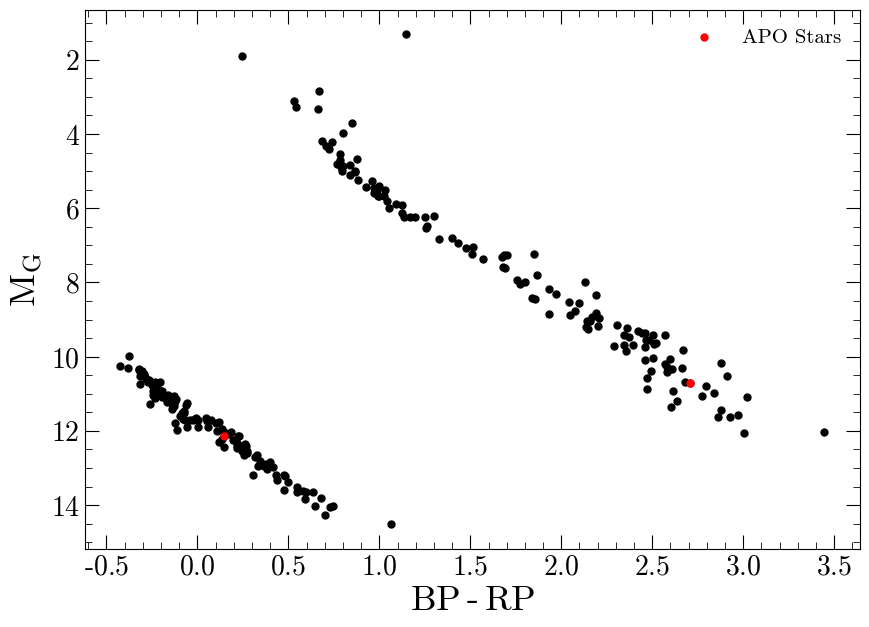

In [28]:


                                                            
plt.figure(figsize=(10,7))


plt.scatter(catalog[mask]['ms_bp_rp'], 
            catalog[mask]['ms_phot_g_mean_mag'] + 5 * np.log10(catalog[mask]['ms_parallax'] / 100), 
            c='k')
plt.scatter(catalog[mask][catalog[mask]['wd_catalog_id'] == 546]['ms_bp_rp'], 
            catalog[mask][catalog[mask]['wd_catalog_id'] == 546]['ms_phot_g_mean_mag'] + 5 * np.log10(catalog[mask][catalog[mask]['wd_catalog_id'] == 546]['ms_parallax'] / 100), 
            c='red', label=r'APO Stars')

plt.scatter(catalog[mask]['wd_bp_rp'], 
            catalog[mask]['wd_phot_g_mean_mag'] + 5 * np.log10(catalog[mask]['ms_parallax'] / 100), 
            c='k')
plt.scatter(catalog[mask][catalog[mask]['wd_catalog_id'] == 546]['wd_bp_rp'], 
            catalog[mask][catalog[mask]['wd_catalog_id'] == 546]['wd_phot_g_mean_mag'] + 5 * np.log10(catalog[mask][catalog[mask]['wd_catalog_id'] == 546]['ms_parallax'] / 100), 
            c='red')

#for i in range(len(catalog[mask])):
#    plt.plot([catalog['wd_bp_rp'][mask][i], catalog['ms_bp_rp'][mask][i]], [catalog['ms_phot_g_mean_mag'][mask][i], catalog['ms_phot_g_mean_mag'][mask][i]], c = 'k', ls='-', alpha=0.3, lw = 0.8, zorder = 0)

plt.legend( framealpha = 0 )

            
plt.gca().invert_yaxis()

plt.ylabel(r'$M_{G}$')
plt.xlabel(r'$BP-RP$')


Text(0.5, 0, 'R_chance_align')

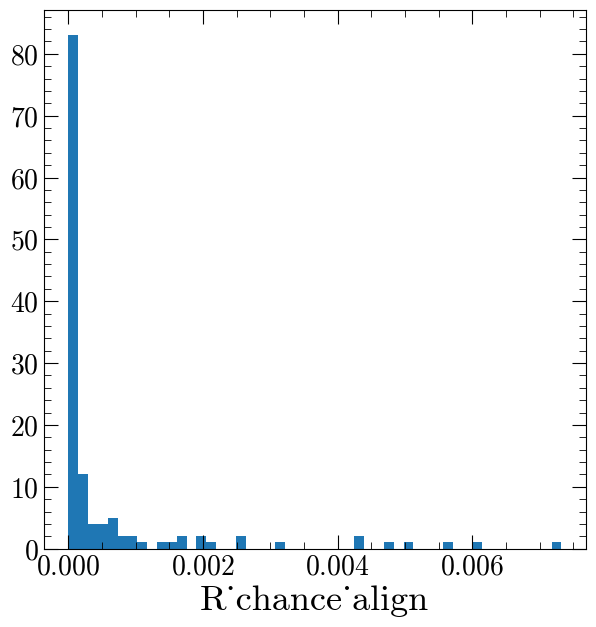

In [29]:
plt.hist(catalog[mask]['R_chance_align'])
plt.xlabel(r'R_chance_align')

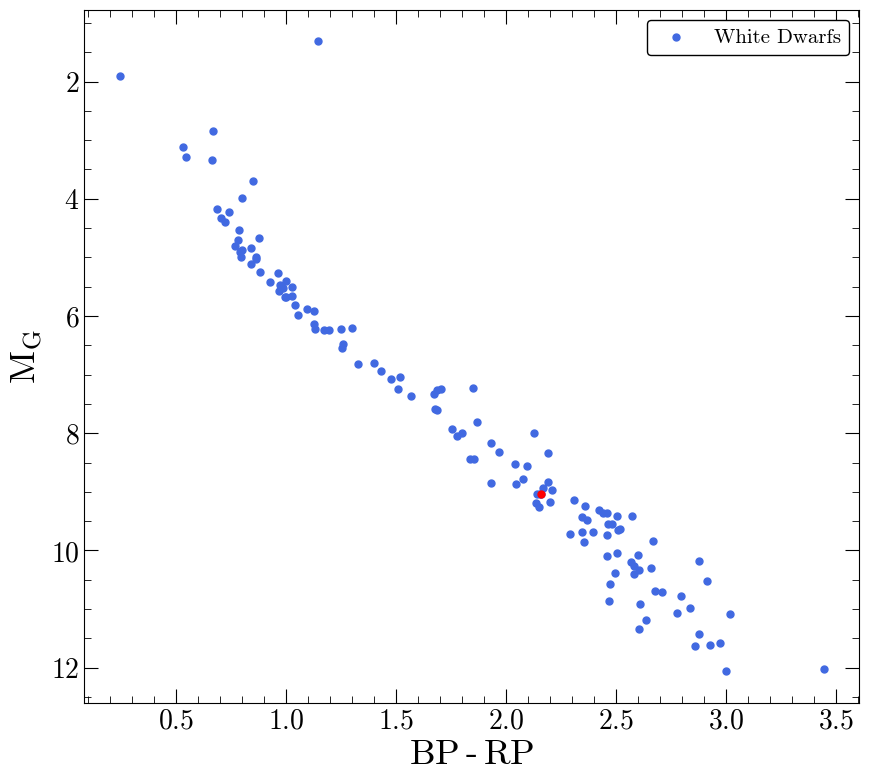

In [30]:
catalog['ms_bp_rp'] = (catalog['ms_phot_bp_mean_mag'] + 5 * np.log10(catalog['ms_parallax'])) - (catalog['ms_phot_rp_mean_mag'] + 5 * np.log10(catalog['ms_parallax']))
                                                            
plt.figure(figsize=(10,9))

plt.scatter(catalog['ms_bp_rp'][mask], 
            catalog['ms_phot_g_mean_mag'][mask] + 5 * np.log10(catalog['ms_parallax'][mask] / 100), 
            c = 'royalblue', label='White Dwarfs')
plt.scatter(catalog[hrmask][catalog[hrmask]['g_redshift'] < 0]['ms_bp_rp'], 
            catalog[hrmask][catalog[hrmask]['g_redshift'] < 0]['ms_phot_g_mean_mag'] + 5 * np.log10(catalog[hrmask][catalog[hrmask]['g_redshift'] < 0]['ms_parallax'] / 100), 
            c='red')
            
plt.gca().invert_yaxis()

plt.ylabel(r'$M_{G}$')
plt.xlabel(r'$BP-RP$')

plt.legend()

In [31]:
a = 0
b = 0
c = 0

for i in catalog['wd_rv_from'][mask]:
    if i == 'sdss5':
        a += 1
    elif i == 'sdss4':
        b += 1
    elif i == 'falcon':
        c += 1

print('sdss5: {}'.format(a))
print('sdss4: {}'.format(b))
print('falcon: {}'.format(c))
print('total: {}'.format(a+b+c))
print('total: {}'.format(len(catalog[mask])))

sdss5: 42
sdss4: 82
falcon: 6
total: 130
total: 130


In [32]:
a = 0
b = 0
c = 0

for i in catalog['ms_rv_from'][mask]:
    if i == 'sdss5':
        a += 1
    elif i == 'sdss4':
        b += 1
    elif i == 'gaia':
        c += 1

print('sdss5: {}'.format(a))
print('sdss4: {}'.format(b))
print('gaia: {}'.format(c))
print('total: {}'.format(a+b+c))

sdss5: 21
sdss4: 1
gaia: 105
total: 127


In [33]:
a = 0
b = 0
c = 0

for i in catalog['radius'][mask]:
    if i < 0.01:
        a += 1
    elif (0.01 <= i < 0.015):
        b += 1
    elif i >= 0.015:
        c += 1

print('high mass: {}'.format(a))
print('mid mass: {}'.format(b))
print('low mass: {}'.format(c))
print('total: {}'.format(a+b+c))

high mass: 1
mid mass: 116
low mass: 13
total: 130


Text(0, 0.5, 'bp-rp')

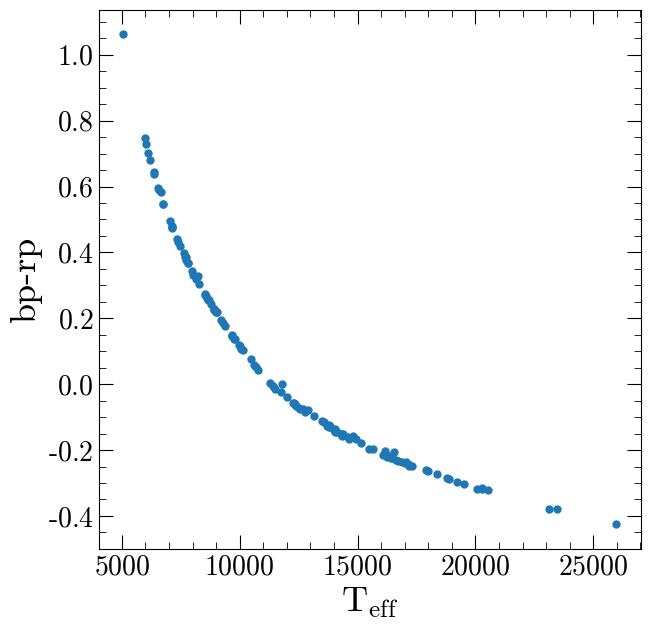

In [34]:
plt.scatter(catalog['phot_teff'][mask], catalog['wd_bp_rp'][mask])
plt.xlabel(r'$T_{eff}$')
plt.ylabel('bp-rp')

In [35]:
catalog['ms_bp_rp'] = catalog['ms_phot_bp_mean_mag'] - catalog['ms_phot_rp_mean_mag']
catalog['ms_m_g'] = catalog['ms_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100)

In [36]:
def logg_cmd_position(radarray, loggarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model
    
    rsun_logg_to_m = WD_models.interp_xy_z_func(x = font_model['color'], y = font_model['logg'],\
                                                z = font_model['Mag'], interp_type = 'linear')
    
    mass = rsun_logg_to_m(radarray, loggarray)
    return mass

<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_60034/1994475163.py:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_60034/1994475163.py:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_60034/1994475163.py:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


In [37]:
colors = np.linspace(-0.5, 1, 100)

theoretical_rvs_7 = logg_cmd_position(colors, 7, 'f', 'f', 'f')
theoretical_rvs_7_5 = logg_cmd_position(colors, 7.5, 'f', 'f', 'f')
theoretical_rvs_8 = logg_cmd_position(colors, 8, 'f', 'f', 'f')
theoretical_rvs_9 = logg_cmd_position(colors, 9, 'f', 'f', 'f')

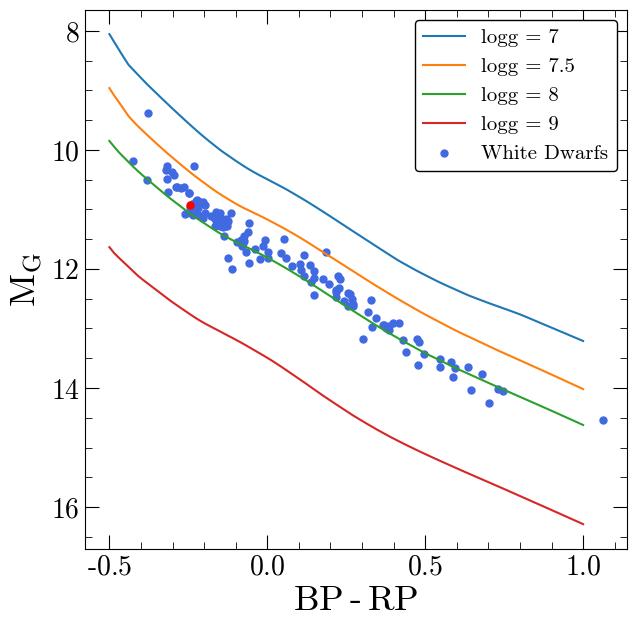

In [38]:
plt.plot(colors, theoretical_rvs_7, label = 'logg = 7')
plt.plot(colors, theoretical_rvs_7_5, label = 'logg = 7.5')

plt.plot(colors, theoretical_rvs_8, label = 'logg = 8')
plt.plot(colors, theoretical_rvs_9, label = 'logg = 9')

plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask], c = 'royalblue', label='White Dwarfs')

plt.scatter(catalog[hrmask][catalog[hrmask]['g_redshift'] < 0]['wd_bp_rp'], 
            catalog[hrmask][catalog[hrmask]['g_redshift'] < 0]['wd_phot_g_mean_mag'] + 5 * np.log10(catalog[hrmask][catalog[hrmask]['g_redshift'] < 0]['ms_parallax'] / 100), 
            c='red')

plt.gca().invert_yaxis()

plt.ylabel(r'$M_G$')
plt.xlabel(r'$BP-RP$')

plt.legend()

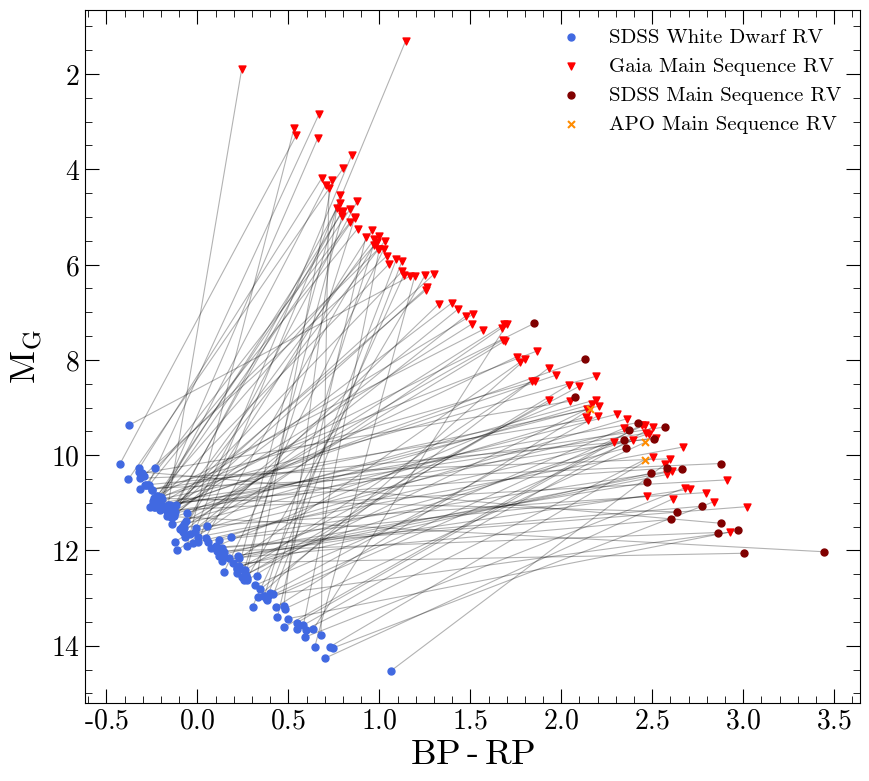

In [39]:
plt.figure(figsize=(10,9))

plt.scatter(catalog[mask]['wd_bp_rp'], catalog[mask]['wd_m_g'], c = 'royalblue', label='SDSS White Dwarf RV', marker = 'o')
#plt.scatter(catalog[mask][catalog[mask]['wd_rv_from'] == 'sdss5']['wd_bp_rp'], catalog[mask][catalog[mask]['wd_rv_from'] == 'sdss5']['wd_m_g'], c = 'royalblue', label='SDSS-V White Dwarf RV', marker = 'v')


plt.scatter(catalog[mask][catalog[mask]['ms_rv_from'] == 'gaia']['ms_bp_rp'], catalog[mask][catalog[mask]['ms_rv_from'] == 'gaia']['ms_m_g'], c = 'red', label='Gaia Main Sequence RV', marker = 'v')
plt.scatter(catalog[mask][np.any([catalog[mask]['ms_rv_from'] == 'sdss4', catalog[mask]['ms_rv_from'] == 'sdss5'], axis = 0)]['ms_bp_rp'], 
            catalog[mask][np.any([catalog[mask]['ms_rv_from'] == 'sdss4', catalog[mask]['ms_rv_from'] == 'sdss5'], axis = 0)]['ms_m_g'], c = 'maroon', label='SDSS Main Sequence RV')
#plt.scatter(catalog[mask][catalog[mask]['ms_rv_from'] == 'sdss5']['ms_bp_rp'], catalog[mask][catalog[mask]['ms_rv_from'] == 'sdss5']['ms_m_g'], c = 'C3', label='SDSS-V Main Sequence RV', marker = 'v')
plt.scatter(catalog[mask][catalog[mask]['ms_rv_from'] == 'apo']['ms_bp_rp'], catalog[mask][catalog[mask]['ms_rv_from'] == 'apo']['ms_m_g'], c = 'darkorange', label='APO Main Sequence RV', marker = 'x')




for i in range(len(catalog[mask])):
    plt.plot([catalog['wd_bp_rp'][mask][i], catalog['ms_bp_rp'][mask][i]], [catalog['wd_m_g'][mask][i], catalog['ms_m_g'][mask][i]], c = 'k', ls='-', alpha=0.3, lw = 0.8, zorder = 0)

plt.gca().invert_yaxis()

plt.ylabel(r'$M_G$')
plt.xlabel(r'$BP-RP$')

plt.legend(framealpha = 0)
plt.savefig('spectra/cmd.pdf')

In [40]:
print(np.median(catalog['sep_AU'][mask]))

2739.5457868444782


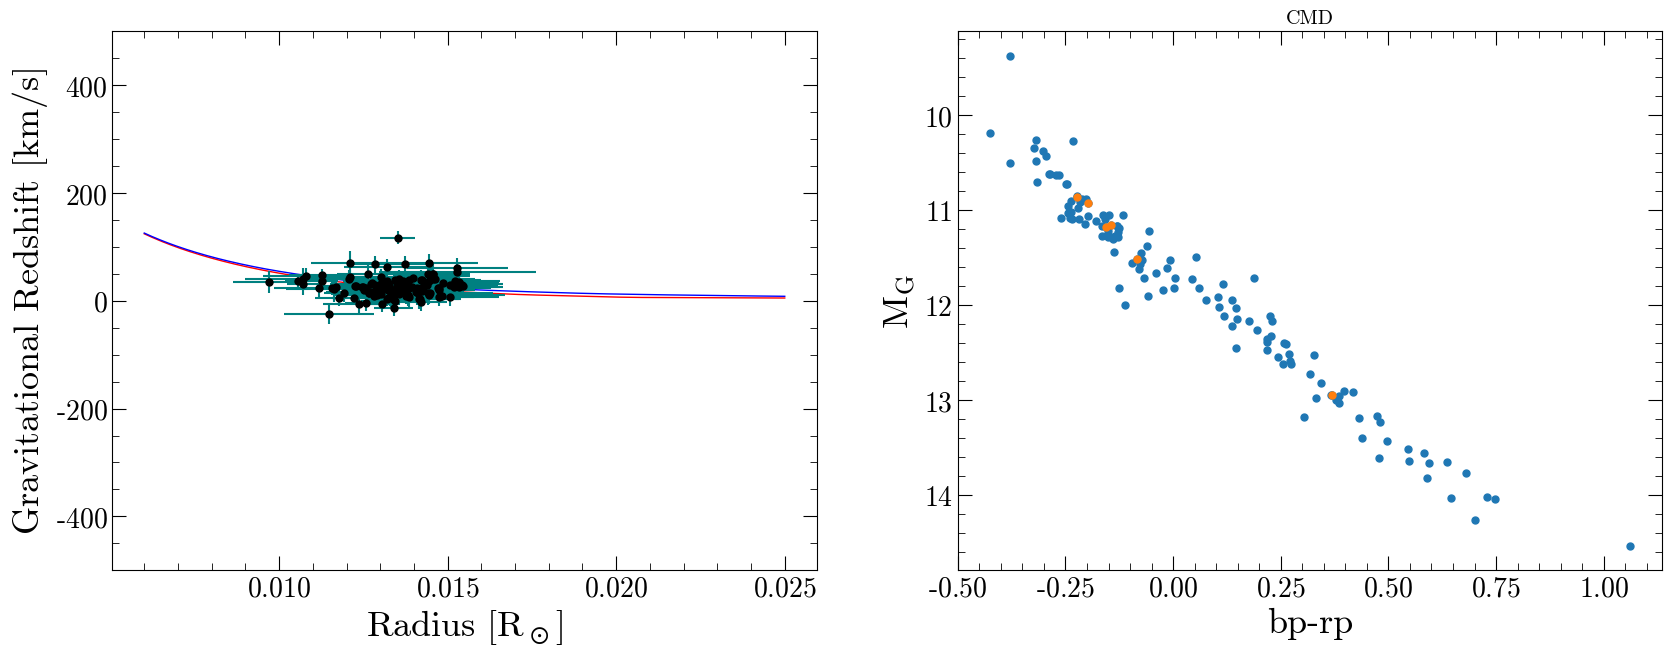

In [41]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

plt.plot(rsuns, theoretical_rvsc, 'red', linestyle = '-',  linewidth = 1)

plt.plot(rsuns, theoretical_rvsh, 'blue', linewidth = 1)


plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')
#plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr = catalog['eg_redshift'][from_falcon], fmt='o', label = 'Data', color='black', ecolor = 'red')

#
#for i in range(len(catalog['radius'][mask])):
#    x = catalog['radius'][mask][i]
#    y = catalog['g_redshift'][mask][i]
#    plt.text(x, y , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)

plt.ylim((-500, 500))
    
plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')

plt.subplot(1,2,2) 

plt.style.use('./stefan.mplstyle')
plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask])
plt.scatter(catalog['wd_bp_rp'][from_falcon], catalog['wd_m_g'][from_falcon])

#for i in range(len(catalog['radius'][mask])):
#    x = catalog['wd_bp_rp'][mask][i]
#    y = catalog['wd_m_g'][mask][i]
#    plt.text(x * (1 + 0.001), y * (1 - 0.001) , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)
    
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()

Text(0.5, 0, '$T_{eff}$')

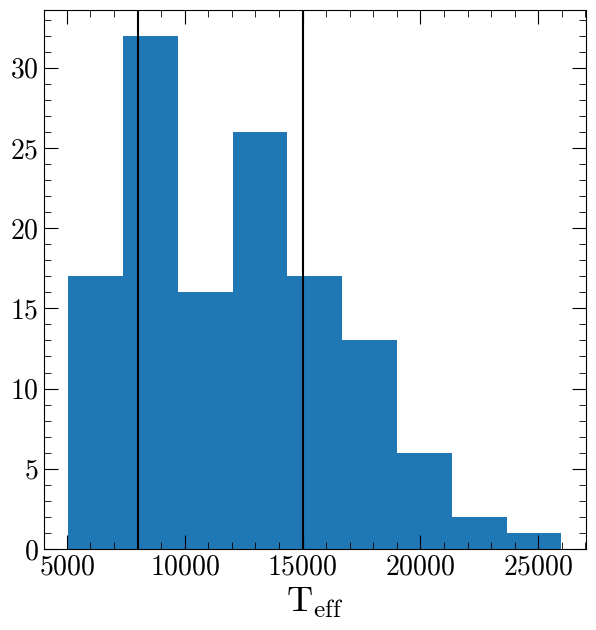

In [42]:
plt.hist(catalog['phot_teff'][mask])
plt.axvline(8000, c='k')
plt.axvline(15000, c='k')
plt.xlabel(r'$T_{eff}$')

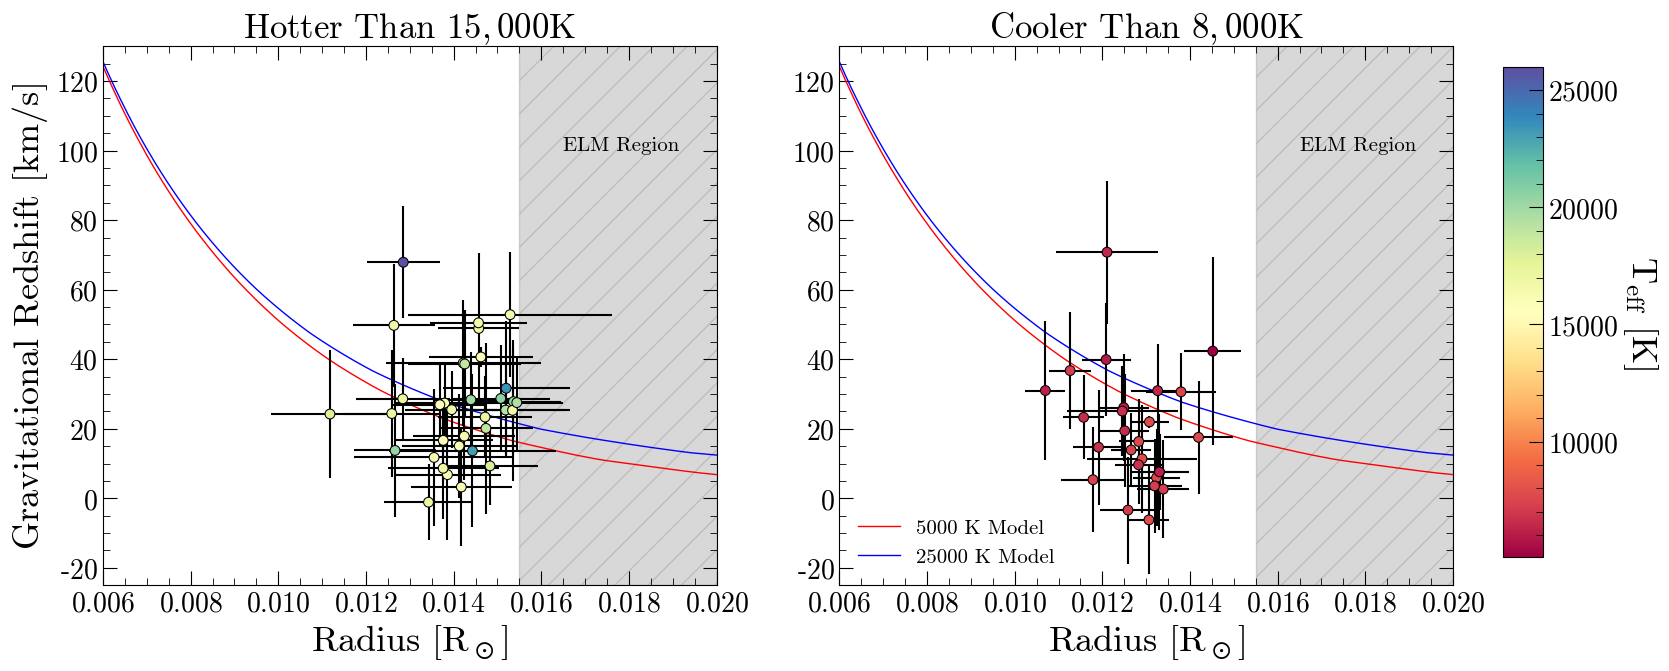

In [43]:
hot_catalog = np.all([catalog['phot_teff'] > 15000], axis = 0)
cool_catalog = np.all([catalog['phot_teff'] < 8000], axis = 0)

hot_mask = np.all([hot_catalog, mask], axis = 0)

cool_mask = np.all([cool_catalog, mask], axis = 0)

''' PLOTTING '''

fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

plt.plot(rsuns, theoretical_rvsc, 'red', linestyle = '-', label = '5000 K Model', linewidth = 1)
plt.plot(rsuns, theoretical_rvsh, 'blue', label = '25000 K Model', linewidth = 1)

# Data

a = plt.scatter(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask],
             c=catalog['phot_teff'][hot_mask], cmap = plt.cm.Spectral, zorder = 10, vmin=min(catalog['phot_teff'][mask]), vmax=max(catalog['phot_teff'][mask]),
              s = 50, edgecolor='k', lw = 0.75)

plt.errorbar(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask], xerr = catalog['e_radius'][hot_mask], yerr = catalog['eg_redshift'][hot_mask], fmt=' ', ecolor = 'black')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlim(0.006, 0.02)
plt.ylim(-25, 130)
plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, 100, 'ELM Region', fontsize = 15)



plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Hotter Than $15,000$K', fontsize = 25)
#plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

plt.plot(rsuns, theoretical_rvsc, 'red', linestyle = '-', label = '5000 K Model', linewidth = 1)

plt.plot(rsuns, theoretical_rvsh, 'blue', label = '25000 K Model', linewidth = 1)

# Data

a = plt.scatter(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask],
             c=catalog['phot_teff'][cool_mask], cmap = plt.cm.Spectral, zorder = 10, vmin=min(catalog['phot_teff'][mask]), vmax=max(catalog['phot_teff'][mask]),
               s = 50, edgecolor='k', lw = .75)

plt.errorbar(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask], xerr = catalog['e_radius'][cool_mask], yerr = catalog['eg_redshift'][cool_mask], fmt=' ', ecolor = 'black')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_\odot]$')

plt.xlim(0.006, 0.02)
plt.ylim(-25, 130)
plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, 100, 'ELM Region', fontsize = 15)



#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Cooler Than $8,000$K', fontsize=25)
plt.legend( framealpha = 0 )
#plt.colorbar()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.02, 0.7])
cbar = fig.colorbar(a, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label(r'$T_{eff}$ $[K]$', rotation = 270)

plt.savefig('spectra/temps_2plots_color.pdf')

In [44]:
np.mean(catalog[hot_mask]['phot_teff'])

18070.11549534338

In [45]:
hot_rv_deriv = np.diff(rv_from_radius(rsuns, np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f')) / np.diff(rsuns)
hot_drv = lambda x: np.interp(x, rsuns[:-1], hot_rv_deriv)

cool_rv_deriv = np.diff(rv_from_radius(rsuns, np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f')) / np.diff(rsuns)
cool_drv = lambda x: np.interp(x, rsuns[:-1], cool_rv_deriv)

print('mean hot teff: {}'.format(np.mean(catalog[hot_mask]['phot_teff'])))
print('mean cold teff: {}'.format(np.mean(catalog[cool_mask]['phot_teff'])))
print('mean teff: {}'.format(np.mean(catalog[mask]['phot_teff'])))

cool_delta_gravz = -999*np.ones(len(catalog))
cool_e_delta_gravz = -999*np.ones(len(catalog))

hot_delta_gravz = -999*np.ones(len(catalog))
hot_e_delta_gravz = -999*np.ones(len(catalog))

delta_gravz = -999*np.ones(len(catalog))
e_delta_gravz = -999*np.ones(len(catalog))

owntemp = -999*np.ones(len(catalog))
e_owntemp = -999*np.ones(len(catalog))


step = 0.0001
size = 25

for i in tqdm(range(len(catalog))):
    cool_delta_gravz[i] = np.mean(catalog['g_redshift'][i] - rv_from_radius(catalog['radius'][i] + np.random.normal(0, catalog['e_radius'][i], size = (1,size)), np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f'))
    cool_e_delta_gravz[i] = ( catalog['eg_redshift'][i]**2 + (catalog['e_radius'][i] * hot_drv(catalog['radius'][i]) )**2 )**(0.5)
    
    hot_delta_gravz[i] = np.mean(catalog['g_redshift'][i] - rv_from_radius(catalog['radius'][i] + np.random.normal(0, catalog['e_radius'][i], size = (1,size)), np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f'))
    hot_e_delta_gravz[i] = ( catalog['eg_redshift'][i]**2 + (catalog['e_radius'][i] * hot_drv(catalog['radius'][i]) )**2 )**(0.5)
        
    delta_gravz[i] = np.mean(catalog['g_redshift'][i] - rv_from_radius(catalog['radius'][i] + np.random.normal(0, catalog['e_radius'][i], size = (1,size)), 12000, 'f', 'f', 'f'))
    e_delta_gravz[i] = ( catalog['eg_redshift'][i]**2 + (catalog['e_radius'][i] * hot_drv(catalog['radius'][i]) )**2 )**(0.5)
    
    owntemp[i] = np.mean(catalog['g_redshift'][i] - rv_from_radius(catalog['radius'][i] + np.random.normal(0, catalog['e_radius'][i], size = (1,size)), 12000, 'f', 'f', 'f'))
    e_owntemp[i] = ( catalog['eg_redshift'][i]**2 + (catalog['e_radius'][i] * hot_drv(catalog['radius'][i]) )**2 )**(0.5)
    

mean hot teff: 18070.11549534338
mean cold teff: 6935.3900072653105
mean teff: 12252.546457415272


100%|█████████████████████████████████████████████████████████████████████████████████| 395/395 [01:01<00:00,  6.43it/s]


In [46]:
catalog['cool_delta_gravz'] = cool_delta_gravz
catalog['cool_e_delta_gravz'] = cool_e_delta_gravz

catalog['hot_delta_gravz'] = hot_delta_gravz
catalog['hot_e_delta_gravz'] = hot_e_delta_gravz

catalog['delta_gravz'] = delta_gravz
catalog['e_delta_gravz'] = e_delta_gravz

catalog['delta_vg_self'] = owntemp
catalog['e_delta_vg_self'] = e_owntemp

In [47]:
np.average(catalog[cool_mask]['cool_delta_gravz'])

-11.03584339307835

In [48]:
print(np.average(catalog[cool_mask]['cool_delta_gravz']))

-11.03584339307835


In [49]:
catalog[catalog['wd_source_id'] == 2545590733671247744] 

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

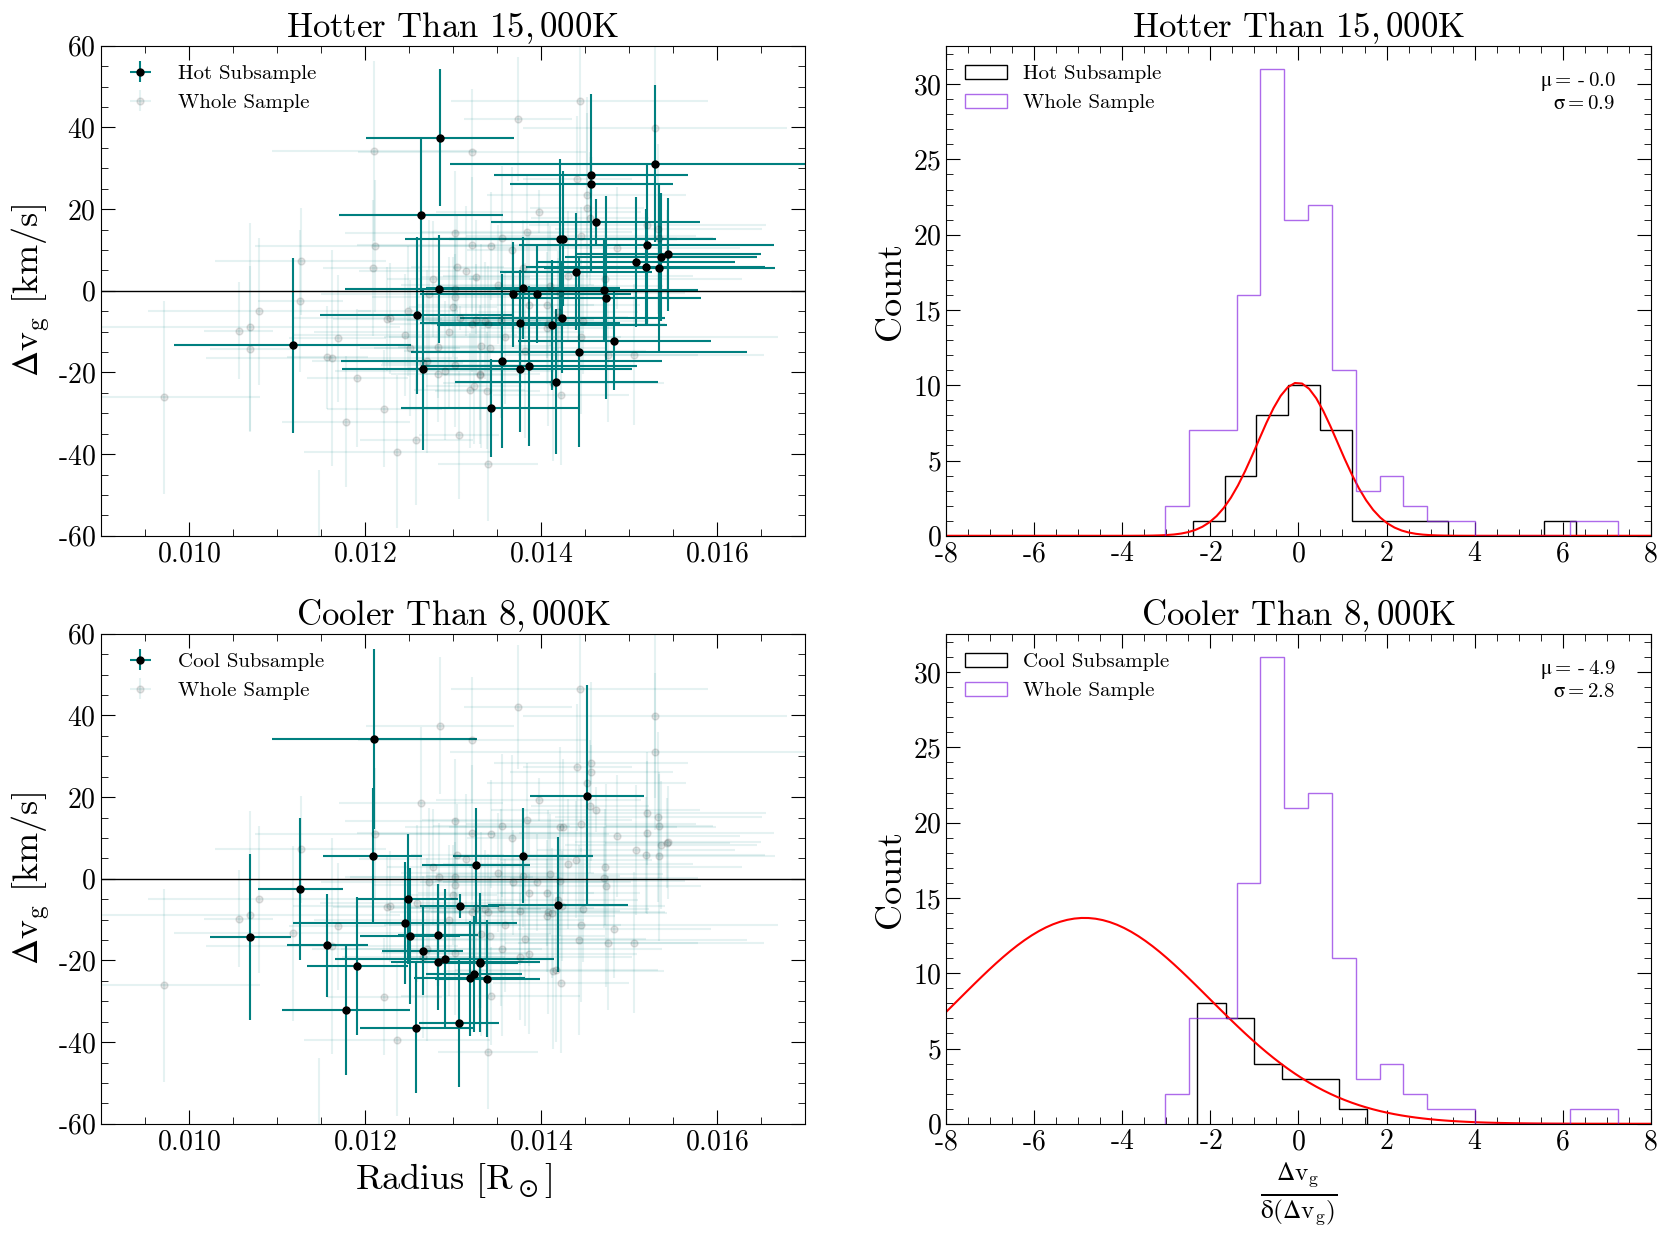

In [50]:
from scipy.optimize import leastsq

fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

init  = [10.0, 0.5, 5]
domain = np.linspace(-8,8,100)


fig = plt.figure(figsize=(20,14))
plt.subplot(2,2,1)


#plt.errorbar(catalog[mask]['radius'], catalog[mask]['delta_gravz'], yerr = catalog[mask]['e_delta_gravz'], fmt = 'o', color='black', ecolor = 'teal', alpha = 0.1)

plt.errorbar(catalog[hot_mask]['radius'], catalog[hot_mask]['delta_gravz'], xerr = catalog[hot_mask]['e_radius'], yerr = catalog[hot_mask]['e_delta_gravz'], fmt = 'o', color='black', ecolor = 'teal', label = 'Hot Subsample')
plt.errorbar(catalog[mask]['radius'], catalog[mask]['delta_gravz'], xerr = catalog[mask]['e_radius'], yerr = catalog[mask]['e_delta_gravz'], fmt = 'o', color='black', ecolor = 'teal', alpha = 0.1, label = 'Whole Sample')


#plt.plot(rsuns, rv_from_radius(rsuns, np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f') - rv_from_radius(rsuns, np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f') , 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)
plt.plot(rsuns, rv_from_radius(rsuns, np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f') - rv_from_radius(rsuns, np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f') , 'k', linestyle = '-', linewidth = 1)

#plt.text(0.95, 0.1, r'$\langle T \rangle = %.1f$' % np.average( catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift'] ) ,
#                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.legend(framealpha = 0, loc = 'upper left')

plt.ylim(-60,60)
plt.xlim(0.009, 0.017)

plt.ylabel(r'$\Delta v_g$ $[km/s]$')
plt.title(r'Hotter Than $15,000$K', fontsize = 25)
#plt.legend(framealpha = 0)

plt.subplot(2,2,2)

n, bins, patches = plt.hist(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['e_delta_gravz'], color = 'k',histtype='step', label = 'Hot Subsample')

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1.5)

n, bins, patches = plt.hist(catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'], color = 'blueviolet', histtype='step', label = 'Whole Sample', alpha = 0.7)

#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))



#plt.axvline(x = c[1], c='r')
#plt.axvline(x = c[1] + c[2], c='r', ls = ':')
#plt.axvline(x = c[1] - c[2], c='r', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.legend(framealpha = 0, loc = 'upper left')

plt.xlim(-8,8)
plt.ylabel(r'Count')
plt.title(r'Hotter Than $15,000$K', fontsize = 25)


plt.subplot(2,2,3)


#plt.errorbar(catalog[mask]['radius'], catalog[mask]['delta_gravz'], yerr = catalog[mask]['e_delta_gravz'], fmt = 'o', color='black', ecolor = 'teal', alpha = 0.1)

plt.errorbar(catalog[cool_mask]['radius'], catalog[cool_mask]['delta_gravz'], xerr = catalog[cool_mask]['e_radius'], yerr = catalog[cool_mask]['e_delta_gravz'], fmt = 'o', color='black', ecolor = 'teal', label = 'Cool Subsample')
plt.errorbar(catalog[mask]['radius'], catalog[mask]['delta_gravz'], xerr = catalog[mask]['e_radius'], yerr = catalog[mask]['e_delta_gravz'], fmt = 'o', color='black', ecolor = 'teal', alpha = 0.1, label = 'Whole Sample')


#plt.plot(rsuns, rv_from_radius(rsuns, np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f') - rv_from_radius(rsuns, np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f') , 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)
plt.plot(rsuns, rv_from_radius(rsuns, np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f') - rv_from_radius(rsuns, np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f') , 'k', linestyle = '-', linewidth = 1)

#plt.text(0.95, 0.1, r'$\langle T \rangle = %.1f$' % np.average( catalog[cool_mask]['delta_gravz'] / catalog[cool_mask]['eg_redshift'] ) ,
#                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.title(r'Cooler Than $8,000$K', fontsize=25)
plt.ylabel(r'$\Delta v_g$ $[km/s]$')

plt.legend(framealpha = 0, loc = 'upper left')


plt.xlabel(r'Radius $[R_\odot]$')
plt.ylim(-60,60)
plt.xlim(0.009, 0.017)
#plt.legend(framealpha = 0)


plt.subplot(2,2,4)

n, bins, patches = plt.hist(catalog[cool_mask]['delta_gravz'] / catalog[cool_mask]['e_delta_gravz'], color = 'k',histtype='step', label = 'Cool Subsample')

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1.5)

n, bins, patches = plt.hist(catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'], color = 'blueviolet', histtype='step', label = 'Whole Sample', alpha = 0.7)

#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))



#plt.axvline(x = c[1], c='r')
#plt.axvline(x = c[1] + c[2], c='r', ls = ':')
#plt.axvline(x = c[1] - c[2], c='r', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Cooler Than $8,000$K', fontsize=25)

plt.legend(framealpha = 0, loc = 'upper left')

plt.xlabel(r'$\frac{\Delta v_g}{\delta(\Delta v_g)}$')
plt.ylabel(r'Count')

fig.savefig('spectra/temp_quantify.pdf')

[3.70398162 3.8461149  3.98824818 4.13038147 4.27251475 4.41464804]


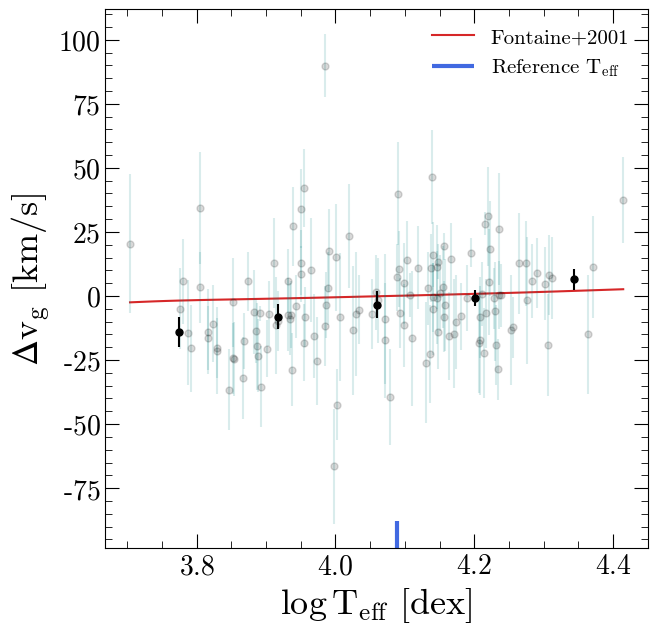

In [51]:
teffs = np.linspace(min(catalog[mask]['phot_teff']), max(catalog[mask]['phot_teff']), 100)
theoretical1 = rv_from_radius(0.014, teffs, 'f', 'f', 'f') - rv_from_radius(0.014, 12000, 'f', 'f', 'f') 
theoretical2 = rv_from_radius(0.013, teffs, 'f', 'f', 'f') - rv_from_radius(0.013, 12000, 'f', 'f', 'f') 
theoretical3 = rv_from_radius(0.012, teffs, 'f', 'f', 'f') - rv_from_radius(0.012, 12000, 'f', 'f', 'f') 
theoretical4 = rv_from_radius(0.011, teffs, 'f', 'f', 'f') - rv_from_radius(0.011, 12000, 'f', 'f', 'f') 

plt.plot(np.log10(teffs), theoretical1, label = 'Fontaine+2001', c = 'C3')
#plt.plot(np.log10(teffs), theoretical2)
#plt.plot(np.log10(teffs), theoretical3)
#plt.plot(np.log10(teffs), theoretical4)

plt.errorbar(np.log10(catalog[mask]['phot_teff']), catalog[mask]['delta_gravz'], yerr = catalog[mask]['e_delta_gravz'], alpha = 0.15, fmt = 'o', color='black', ecolor = 'teal')

n = np.histogram(np.log10(catalog[mask]['phot_teff']), bins = 5)
centers = n[1][:-1] + np.diff(n[1])/2

print(n[1])

median = []
e_median = []
for i in range(len(n[1])-1):
    tempmask = np.all([np.log10(catalog['phot_teff']) > n[1][i], np.log10(catalog['phot_teff']) < n[1][i+1], mask], axis = 0)
    median.append(np.median(catalog[tempmask]['delta_gravz']))
    e_median.append(1.2533*np.std(catalog[tempmask]['delta_gravz']) / np.sqrt(len(catalog[tempmask])))
    
plt.errorbar(centers, median, yerr = e_median, c = 'k', fmt = 'o')

ymin, ymax = plt.ylim()

plt.ylabel(r'$\Delta v_g$ $[km/s]$')
plt.xlabel(r'$\log T_{eff}$ $[dex]$')
plt.vlines(np.log10(np.mean(catalog[mask]['phot_teff'])), ymin = ymin, ymax = ymin + 0.05*(ymax - ymin), color = 'royalblue', lw = 3, label = r'Reference $T_{eff}$')
plt.legend(framealpha = 0)


plt.ylim(ymin, ymax)

plt.savefig('spectra/vg_teff.pdf')

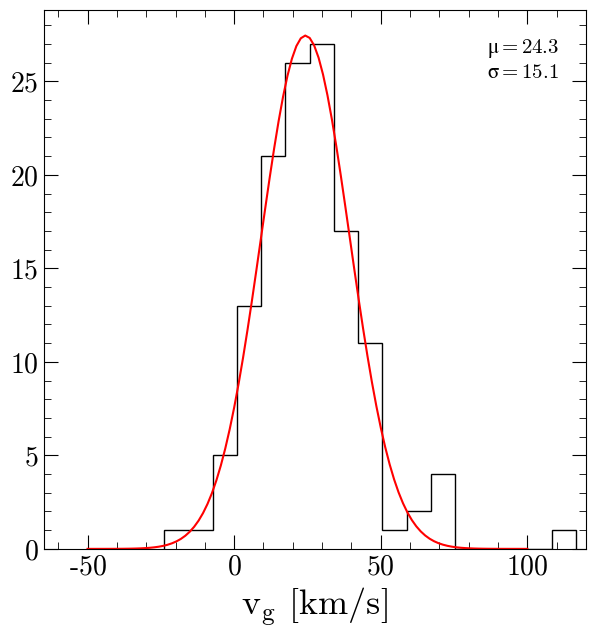

In [52]:
domain = np.linspace(-50, 100, 100)

n, bins, patches = plt.hist(catalog[mask]['g_redshift'], color = 'k',histtype='step')
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1.5)
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))


#plt.axvline(x = c[1], c='r')
#plt.axvline(x = c[1] + c[2], c='r', ls = ':')
#plt.axvline(x = c[1] - c[2], c='r', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-65, 120)
plt.xlabel(r'$v_g$ $[km/s]$')

#plt.ylabel(r'N')

plt.savefig('spectra/gravz_dist.pdf')

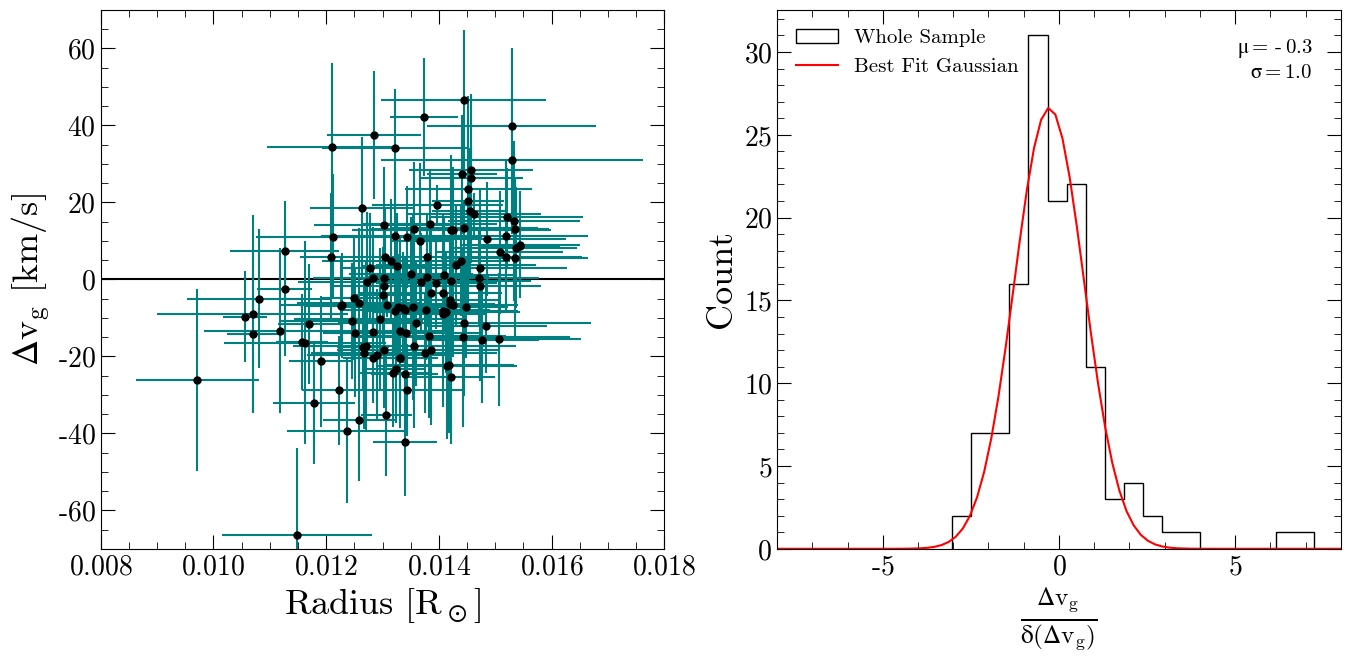

In [53]:
f = plt.figure(figsize=(16,7))


plt.subplot(1,2,1)

domain = np.linspace(-10,10,100)



plt.errorbar(catalog[mask]['radius'], catalog[mask]['delta_gravz'], yerr = catalog[mask]['e_delta_gravz'], xerr = catalog[mask]['e_radius'], fmt = 'o', color='black', ecolor = 'teal')

#plt.plot(rsuns, rv_from_radius(rsuns, np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f') - rv_from_radius(rsuns, np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f') , 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)
#plt.plot(rsuns, rv_from_radius(rsuns, np.mean(catalog[cool_mask]['phot_teff']), 'f', 'f', 'f') - rv_from_radius(rsuns, np.mean(catalog[hot_mask]['phot_teff']), 'f', 'f', 'f') , 'blue', linestyle = '-', label = '3,500 K Model', linewidth = 1)

plt.plot(rsuns, rv_from_radius(rsuns, np.mean(catalog[mask]['phot_teff']), 'f', 'f', 'f') - rv_from_radius(rsuns, np.mean(catalog[mask]['phot_teff']), 'f', 'f', 'f') , 'k', linestyle = '-', label = '3,500 K Model', linewidth = 1.5, zorder = 1)

#plt.text(0.975, 0.95, r'$\langle T \rangle = %.1f$' % np.average( catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'] ) ,
#                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.ylim(-70,70)
plt.xlim(0.008, 0.018)
plt.ylabel(r'$\Delta v_g$ $[km/s]$')
plt.xlabel(r'Radius $[R_\odot]$')
#plt.title(r'Hotter Than $15,000$K', fontsize = 25)




plt.subplot(1,2,2)


n, bins, patches = plt.hist(catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'], color = 'k',histtype='step', label = 'Whole Sample')
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='r', linewidth = 1.5, label = 'Best Fit Gaussian')
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))



#plt.axvline(x = c[1], c='r')
#plt.axvline(x = c[1] + c[2], c='r', ls = ':')
#plt.axvline(x = c[1] - c[2], c='r', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( np.abs(c[2]) ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.xlabel(r'$\frac{\Delta v_g}{\delta(\Delta v_g)}$')
plt.ylabel(r'Count')
plt.legend(framealpha = 0, loc = 'upper left')

plt.savefig('spectra/quantify_total_sample.pdf')

#plt.title(r'All White Dwarfs', fontsize = 25)

Text(0.5, 0.01, '$T$ Value (W.R.T. Mean Cool Temperature Model)')

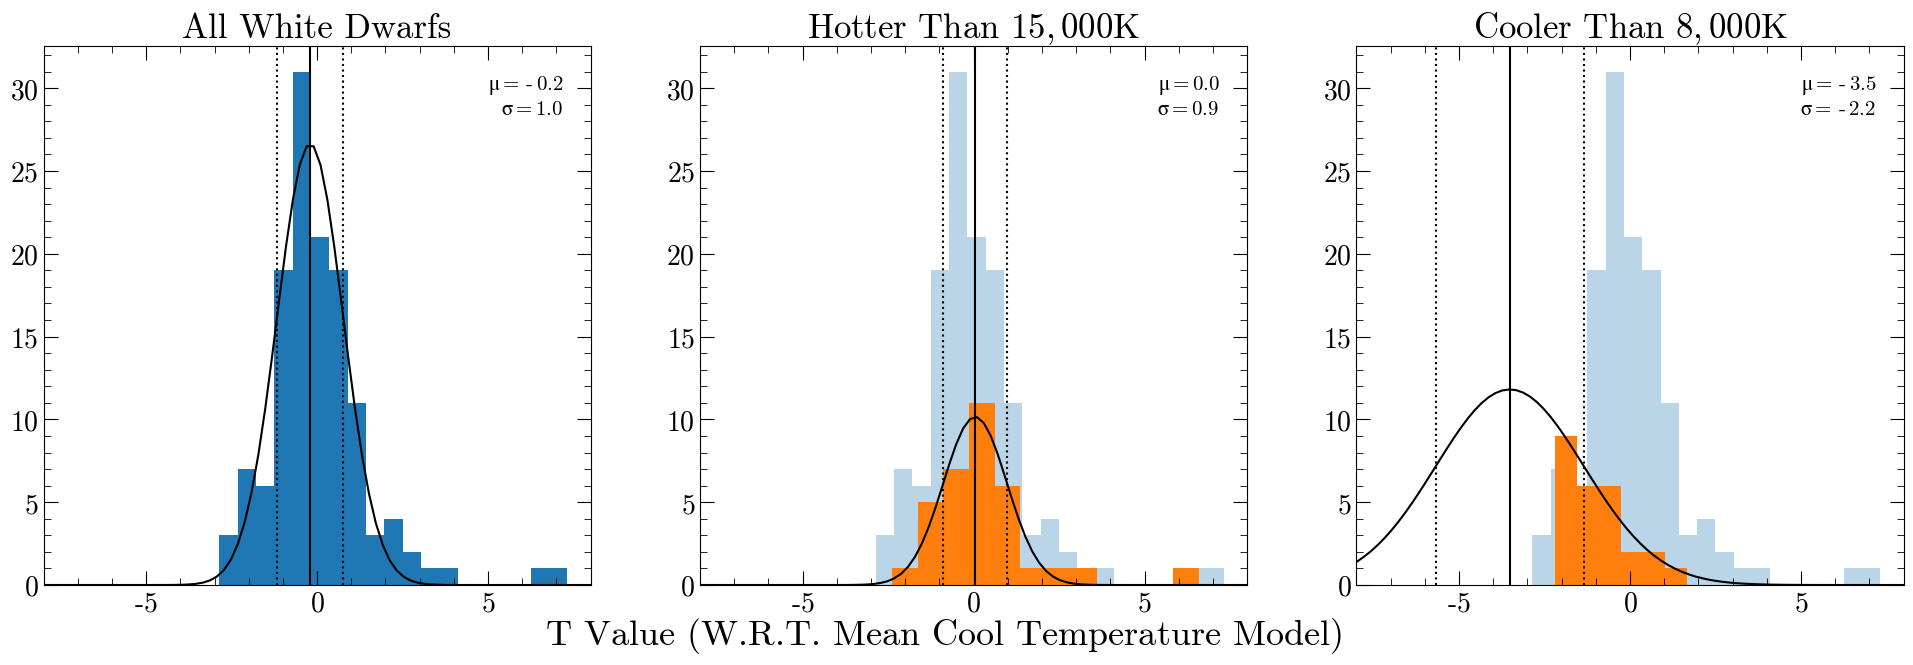

In [54]:


f = plt.figure(figsize=(24,7))

plt.subplot(1,3,1)


n, bins, patches = plt.hist(catalog[mask]['cool_delta_gravz'] / catalog[mask]['cool_e_delta_gravz'])
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'All White Dwarfs', fontsize = 25)

plt.subplot(1,3,2)



n, bins, patches = plt.hist(catalog[mask]['cool_delta_gravz'] / catalog[mask]['cool_e_delta_gravz'], alpha = 0.3)



n, bins, patches = plt.hist(catalog[hot_mask]['cool_delta_gravz'] / catalog[hot_mask]['cool_e_delta_gravz'])
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Hotter Than $15,000$K', fontsize = 25)

plt.subplot(1,3,3)

n, bins, patches = plt.hist(catalog[mask]['cool_delta_gravz'] / catalog[mask]['cool_e_delta_gravz'], alpha = 0.3)



n, bins, patches =  plt.hist(catalog[cool_mask]['cool_delta_gravz'] / catalog[cool_mask]['cool_e_delta_gravz'])
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[cool_mask]['delta_gravz'] / catalog[cool_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Cooler Than $8,000$K', fontsize=25)

f.supxlabel(r'$T$ Value (W.R.T. Mean Cool Temperature Model)', fontsize = 26)

Text(0.5, 0.01, '$t$ Value (W.R.T. Mean Temperature Model)')

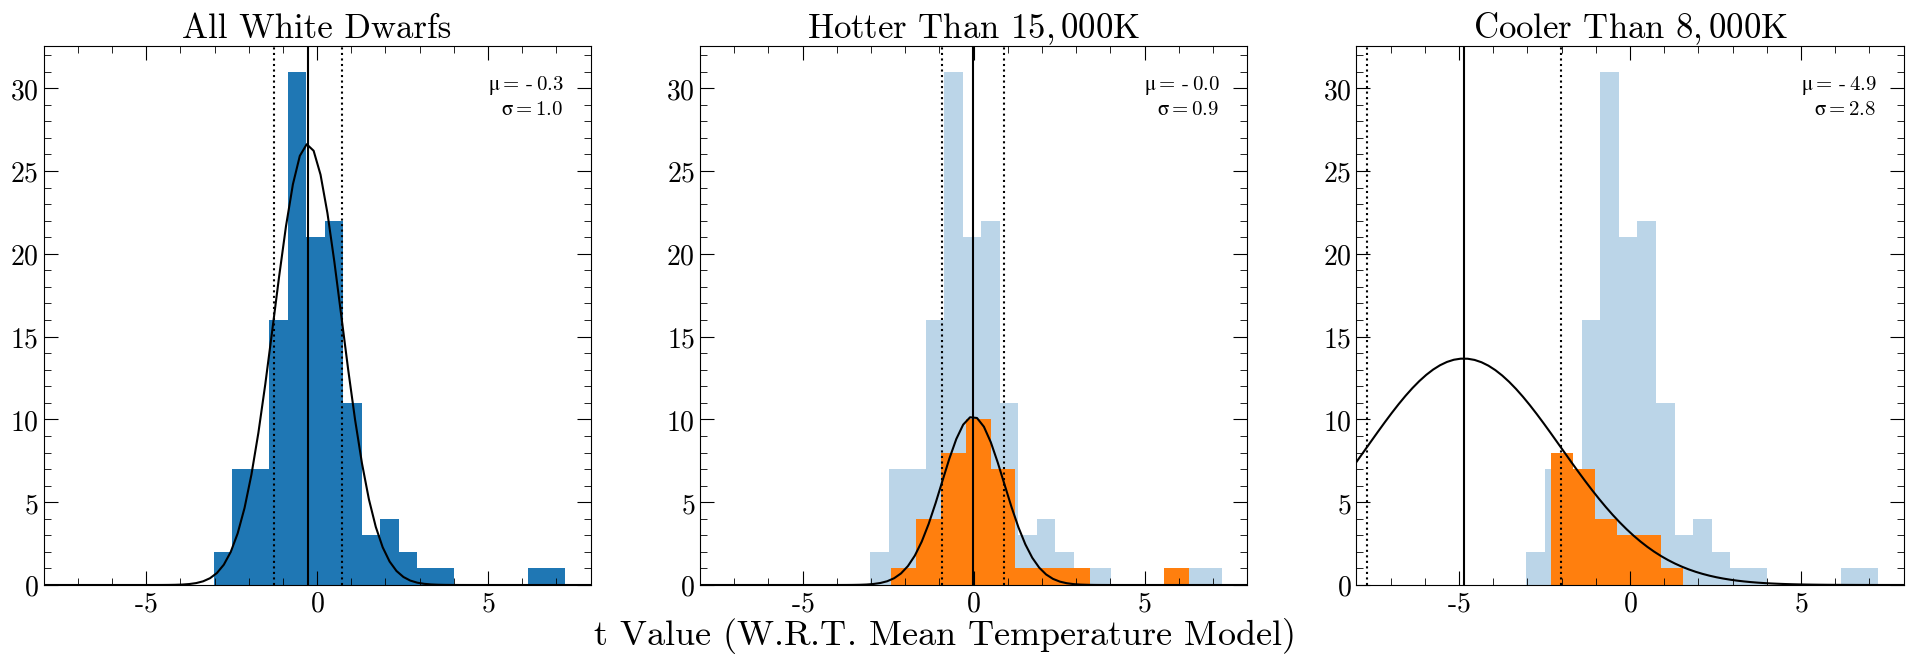

In [55]:
f = plt.figure(figsize=(24,7))

plt.subplot(1,3,1)


n, bins, patches = plt.hist(catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'])
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'All White Dwarfs', fontsize = 25)

plt.subplot(1,3,2)



n, bins, patches = plt.hist(catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'], alpha = 0.3)



n, bins, patches = plt.hist(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['e_delta_gravz'])
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Hotter Than $15,000$K', fontsize = 25)

plt.subplot(1,3,3)

n, bins, patches = plt.hist(catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'], alpha = 0.3)



n, bins, patches =  plt.hist(catalog[cool_mask]['delta_gravz'] / catalog[cool_mask]['e_delta_gravz'])
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[cool_mask]['delta_gravz'] / catalog[cool_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Cooler Than $8,000$K', fontsize=25)

f.supxlabel(r'$t$ Value (W.R.T. Mean Temperature Model)', fontsize = 26)

Text(0.5, 0.01, '$T$ Value (W.R.T. Mean Temperature Model)')

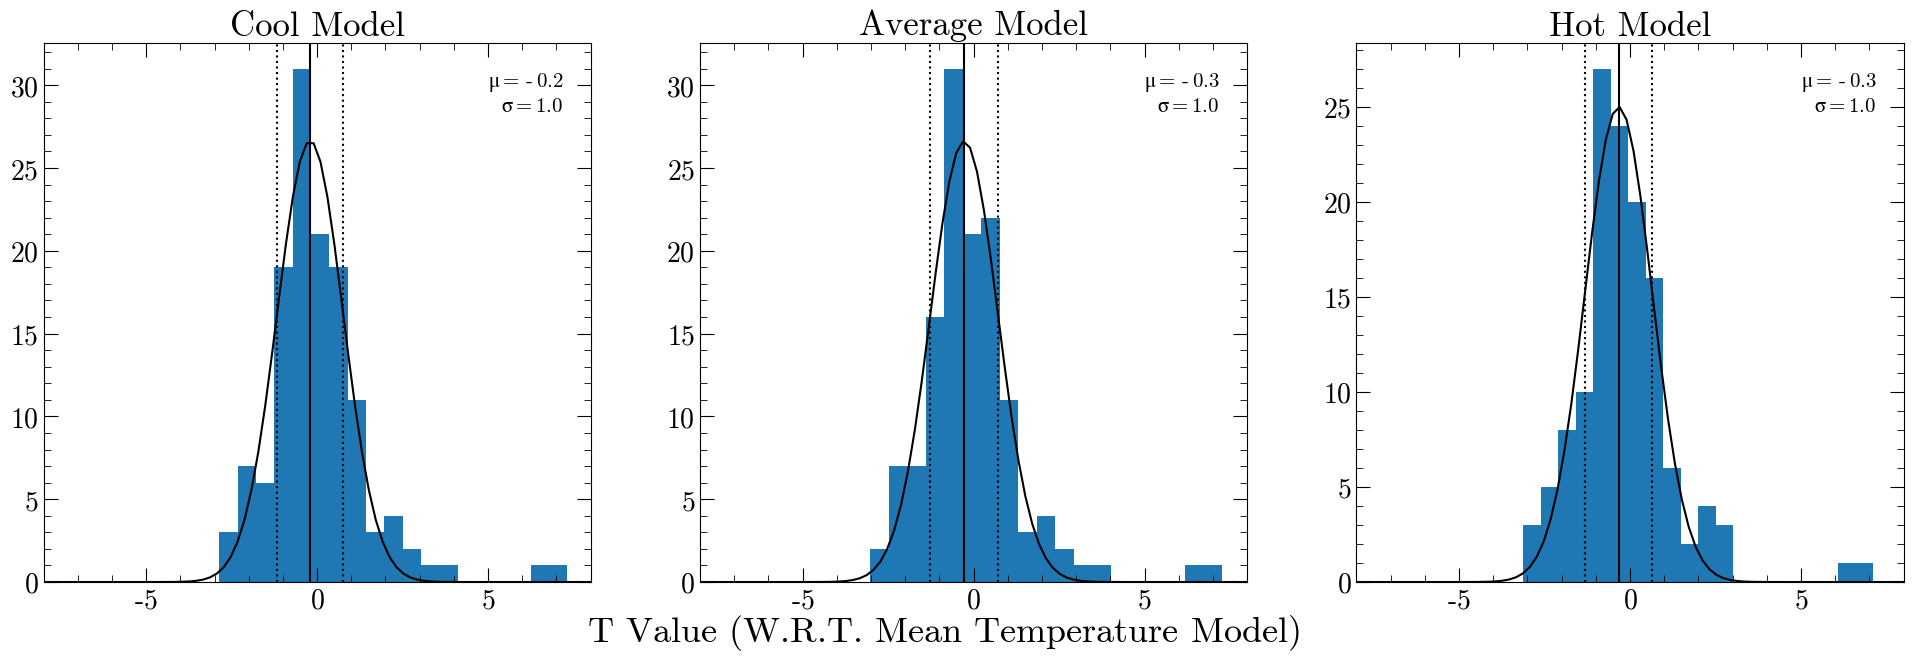

In [56]:
f = plt.figure(figsize=(24,7))

plt.subplot(1,3,1)


n, bins, patches = plt.hist(catalog[mask]['cool_delta_gravz'] / catalog[mask]['cool_e_delta_gravz'])
x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Cool Model', fontsize = 25)

plt.subplot(1,3,2)



n, bins, patches = plt.hist(catalog[mask]['delta_gravz'] / catalog[mask]['e_delta_gravz'])

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[hot_mask]['delta_gravz'] / catalog[hot_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Average Model', fontsize = 25)

plt.subplot(1,3,3)

n, bins, patches = plt.hist(catalog[mask]['hot_delta_gravz'] / catalog[mask]['hot_e_delta_gravz'])

x = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins) - 1)]

out   = leastsq( errfunc, init, args=(x, n))
c = out[0]

plt.plot(domain, fitfunc(c, domain), c='k')
#plt.axvline(x = np.mean(catalog[cool_mask]['delta_gravz'] / catalog[cool_mask]['eg_redshift']))
plt.axvline(x = c[1], c='k')
plt.axvline(x = c[1] + c[2], c='k', ls = ':')
plt.axvline(x = c[1] - c[2], c='k', ls = ':')

plt.text(0.95, 0.95, r'$\mu = %.1f$' % c[1] ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)
plt.text(0.95, 0.9, r'$\sigma = %.1f$' % np.average( c[2] ) ,
                    transform = plt.gca().transAxes, ha = 'right', va = 'top', fontsize = 15)

plt.xlim(-8,8)
plt.title(r'Hot Model', fontsize=25)

f.supxlabel(r'$T$ Value (W.R.T. Mean Temperature Model)', fontsize = 26)

In [57]:


arr1 = np.array([catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask]])
arr2 = np.array([catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask]])

print(KS2D.ks2d2s(arr1, arr2))



(0.6787330316742081, 9.867552977444278e-06)


Text(0.5, 0, 'Radius $[R_\\odot]$')

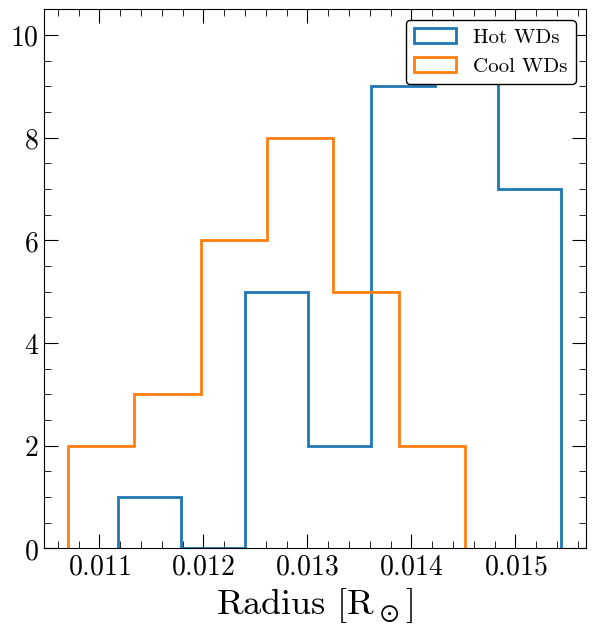

In [58]:
plt.hist(catalog['radius'][hot_mask], label = 'Hot WDs', histtype='step', lw = 2)
plt.hist(catalog['radius'][cool_mask], label = 'Cool WDs', histtype='step', lw = 2)

plt.legend()
plt.xlabel(r'Radius $[R_\odot]$')

0.009714655155405781
0.015441431715290891
[0.00971466 0.01086001 0.01200537 0.01315072 0.01429608 0.01544143]
(0.009714655155405781, 0.010860010467382802)
(0.009714655155405781, 0.010860010467382802)


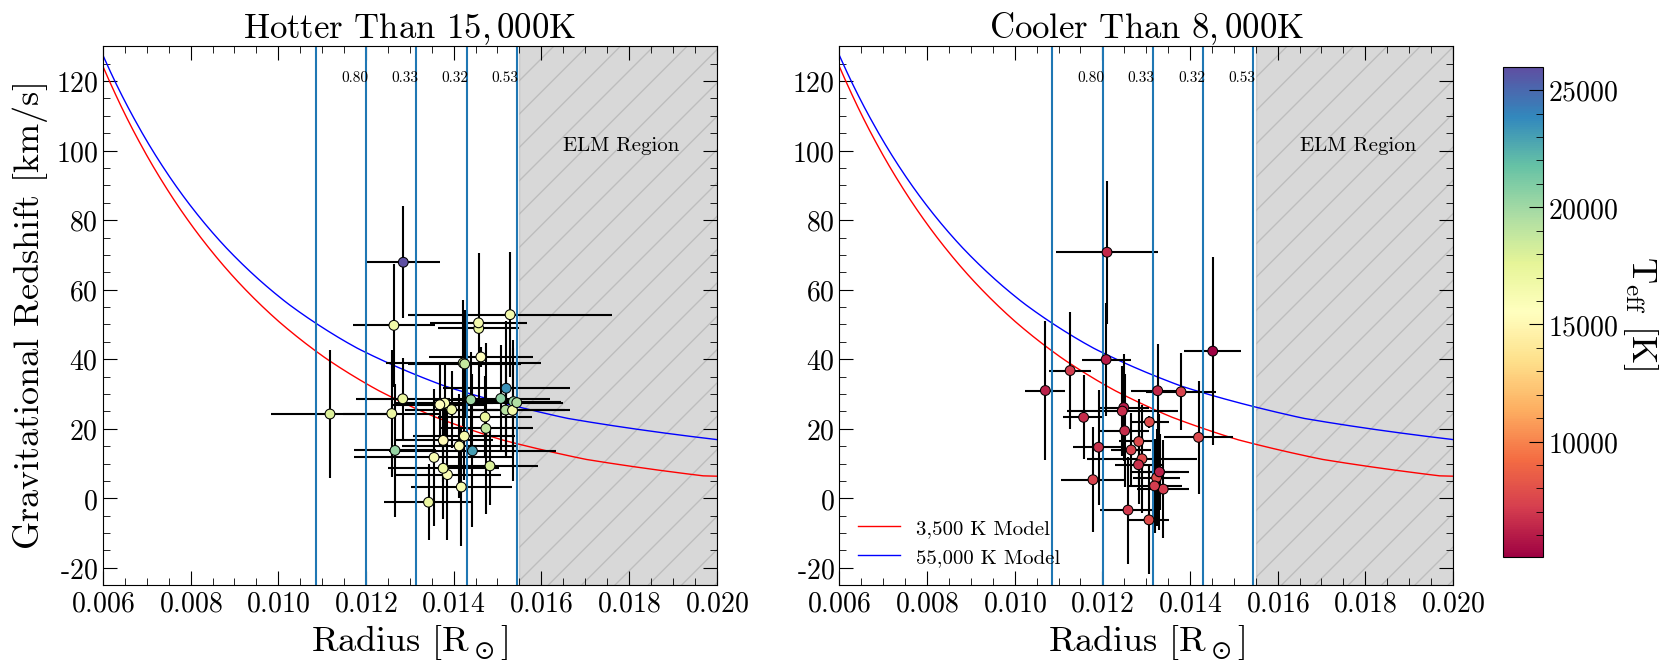

In [59]:
from scipy import stats

print(min(catalog[mask]['radius']))
print(max(catalog[mask]['radius']))
bins = np.linspace(min(catalog[mask]['radius']), max(catalog[mask]['radius']), 6)
print(bins)


        
fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

a = plt.scatter(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask],
             c=catalog['phot_teff'][hot_mask], cmap = plt.cm.Spectral, zorder = 10, vmin=min(catalog['phot_teff'][mask]), vmax=max(catalog['phot_teff'][mask]),
              s = 50, edgecolor='k', lw = 0.75)

plt.errorbar(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask], xerr = catalog['e_radius'][hot_mask], yerr = catalog['eg_redshift'][hot_mask], fmt=' ', ecolor = 'black')

for i in range(len(bins)-1):
    lower = bins[i]
    upper = bins[i+1]
    
    t_hot = np.all([catalog['radius'] < upper, catalog['radius'] >= lower, hot_mask], axis = 0)
    t_cool = np.all([catalog['radius'] < upper, catalog['radius'] >= lower, cool_mask], axis = 0)
    
    try:
        plt.axvline(x = upper)
        plt.text((upper + lower) / 2, 120, '{:2.2f}'.format(stats.ks_2samp(catalog['g_redshift'][t_hot], catalog['g_redshift'][t_cool]).pvalue), fontsize = 11)
    except:
        print('(' + str(lower) + ', ' + str(upper) + ')')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlim(0.006, 0.02)
plt.ylim(-25, 130)
plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, 100, 'ELM Region', fontsize = 15)



plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Hotter Than $15,000$K', fontsize = 25)
#plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

a = plt.scatter(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask],
             c=catalog['phot_teff'][cool_mask], cmap = plt.cm.Spectral, zorder = 10, vmin=min(catalog['phot_teff'][mask]), vmax=max(catalog['phot_teff'][mask]),
               s = 50, edgecolor='k', lw = .75)

plt.errorbar(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask], xerr = catalog['e_radius'][cool_mask], yerr = catalog['eg_redshift'][cool_mask], fmt=' ', ecolor = 'black')

for i in range(len(bins)-1):
    lower = bins[i]
    upper = bins[i+1]
    
    t_hot = np.all([catalog['radius'] < upper, catalog['radius'] >= lower, hot_mask], axis = 0)
    t_cool = np.all([catalog['radius'] < upper, catalog['radius'] >= lower, cool_mask], axis = 0)
    
    try:
        plt.axvline(x = upper)
        plt.text((upper + lower) / 2, 120, '{:2.2f}'.format(stats.ks_2samp(catalog['g_redshift'][t_hot], catalog['g_redshift'][t_cool]).pvalue), fontsize = 11)
    except:
        print('(' + str(lower) + ', ' + str(upper) + ')')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_\odot]$')

plt.xlim(0.006, 0.02)
plt.ylim(-25, 130)
plt.axvspan(0.0155, 0.02, hatch ='/', color = 'grey', alpha = 0.3)
plt.text(0.0165, 100, 'ELM Region', fontsize = 15)



#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Cooler Than $8,000$K', fontsize=25)
plt.legend( framealpha = 0 )
#plt.colorbar()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.02, 0.7])
cbar = fig.colorbar(a, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label(r'$T_{eff}$ $[K]$', rotation = 270)


In [60]:
catalog[mask][['wd_source_id', 'r_med_geo', 'wd_ra', 'wd_dec', 'phot_teff', 'radius', 'e_radius']].write('data.csv', overwrite=True)

In [61]:
print(max(catalog[mask]['phot_teff']))
print(min(catalog[mask]['phot_teff']))

25980.53184574886
5058.032501533029


In [62]:
relevant = np.all([hrmask, catalog['ms_rv_from'] == 'apo', catalog['wd_rv_from'] == 'sdss4'], axis = 0)
catalog[hrmask][catalog[hrmask]['ms_rv_from'] == 'apo']

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [63]:
def continuum_normalize(wl, fl, ivar = None, avg_size = 150, ret_cont = False):
    
    fl_norm = np.zeros(np.size(fl))
    fl_cont = np.zeros(np.size(fl))
    
    ivar_yes = 0
    if ivar is not None:
        ivar_yes = 1
        ivar_norm = np.zeros(np.size(fl))
        
    for i in range(np.size(wl)):
        wl_clip = ((wl[i]-avg_size/2)<wl) * (wl<(wl[i]+avg_size/2))
        fl_cont[i] = np.median(fl[wl_clip])
        if ivar_yes:
            ivar_norm[i] = ivar[i]*np.median(fl[wl_clip])**2
    
    fl_norm = fl/fl_cont
    
    if ret_cont:
        if ivar_yes:
            return wl, fl_norm, ivar_norm, fl_cont
        else:
            return wl, fl_norm, fl_cont
    else:
        if ivar_yes:
            return wl, fl_norm, ivar_norm
        else:
            return wl, fl_norm

In [64]:
i = 0
id_ = 944149092879368320

import corv

ms_fits = fits.open(catalog[catalog['wd_source_id'] == id_]['paths_2'][i])

#ms_wl = 10**ms_fits[1].data['LOGLAM']
#ms_fl = ms_fits[1].data['FLUX']



ms_wl = corv.utils.air2vac(ms_fits[0].data[0])
ms_fl = ms_fits[0].data[1]

ms_wl, ms_fl = continuum_normalize(ms_wl, ms_fl, avg_size = 150)

building montreal da model
0.0
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [65]:
catalog[catalog['wd_source_id'] == id_]#['paths_1']

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [66]:
from astroquery.sdss import SDSS

wd_fits = SDSS.get_spectra(plate=catalog[catalog['wd_source_id'] == id_]['wd_plate'][i], fiberID=catalog[catalog['wd_source_id'] == id_]['wd_fiberid'][i], 
                           mjd=catalog[catalog['wd_source_id'] == id_]['wd_mjd'][i])[0]
wd_wl = 10**wd_fits[1].data['loglam']
wd_fl = wd_fits[1].data['flux']
wd_ivar = wd_fits[1].data['ivar']

#wd_fits = fits.open(catalog[catalog['wd_source_id'] == 944149092879368320]['paths_1'][i])

wd_wl = 10**wd_fits[1].data['LOGLAM']
wd_fl = wd_fits[1].data['FLUX']
wd_ivar = wd_fits[1].data['IVAR']

wd_wl, wd_fl, _ = corv.utils.cont_norm_line(wd_wl, wd_fl, wd_ivar, 6564.61, 200, 25)

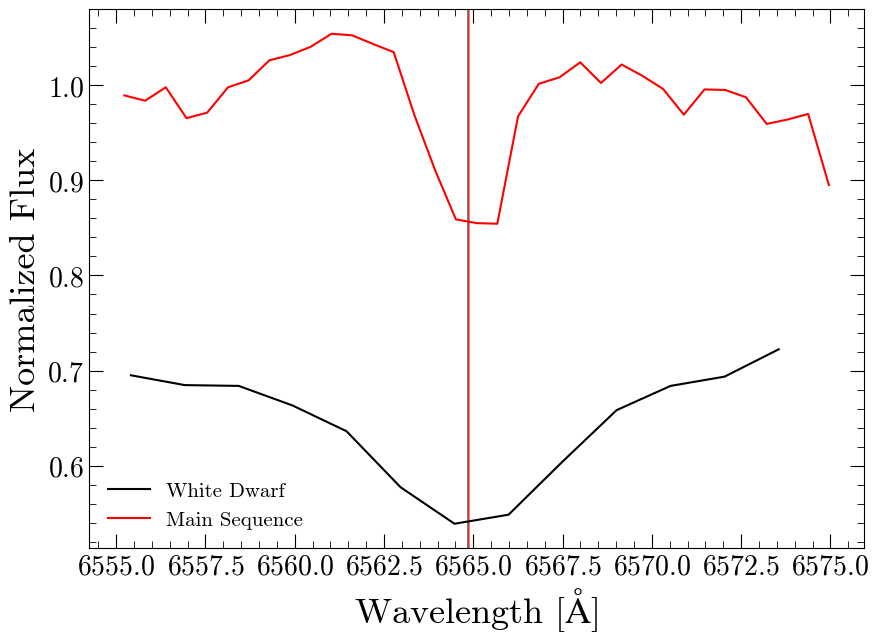

In [67]:
plt.figure(figsize = (10,7))

lo, hi = 6555, 6575

ms_mask = (lo < ms_wl) * (ms_wl < hi)
wd_mask = (lo < wd_wl) * (wd_wl < hi)

plt.plot(wd_wl[wd_mask], wd_fl[wd_mask], color = 'k', label = 'White Dwarf')
plt.plot(ms_wl[ms_mask], ms_fl[ms_mask], color = 'red', label = 'Main Sequence')

#plt.axvline(x = 6564.61 + 6564.61 * ((catalog[relevant]['wd_rv'][i] + catalog[relevant]['wd_e_rv'][i]) / 2.99792458e5), zorder=0, c='k', alpha = 0.5, ls = ':')
plt.axvline(x = 6564.61 + 6564.61 * (catalog[catalog['wd_source_id'] == id_]['wd_rv'][i] / 2.99792458e5) , zorder=0, c='k', alpha = 0.5)
#plt.axvline(x = 6564.61 + 6564.61 * ((catalog[relevant]['wd_rv'][i] - catalog[relevant]['wd_e_rv'][i]) / 2.99792458e5), zorder=0, c='k', alpha = 0.5, ls = ':')


plt.axvline(x = 6564.61 + 6564.61 * (catalog[catalog['wd_source_id'] == id_]['radial_velocity'][i] / 2.99792458e5), zorder=0, c='red', alpha = 0.5)


plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel('Normalized Flux')

plt.legend( framealpha = 0 )
plt.savefig('spectra/comparison.pdf')

/tmp/ipykernel_60034/3073833097.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(catalog['radius'][hot_mask], vg_r_to_m(catalog['g_redshift'][hot_mask], catalog['radius'][hot_mask]),
/tmp/ipykernel_60034/3073833097.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(catalog['radius'][cool_mask], vg_r_to_m(catalog['g_redshift'][cool_mask], catalog['radius'][cool_mask]),


<ErrorbarContainer object of 3 artists>

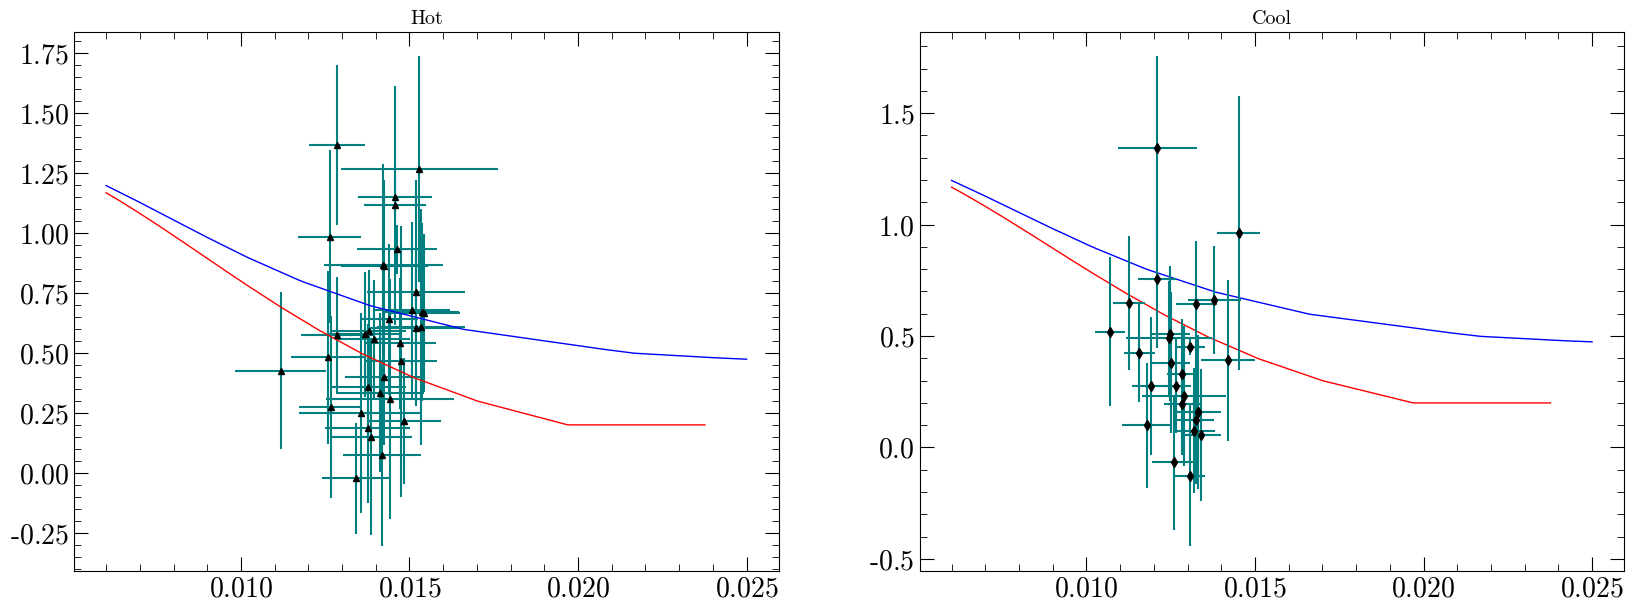

In [68]:
fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

plt.title('Hot')

plt.errorbar(catalog['radius'][hot_mask], vg_r_to_m(catalog['g_redshift'][hot_mask], catalog['radius'][hot_mask]), 
             xerr = catalog['e_radius'][hot_mask], yerr = e_m(catalog['g_redshift'][hot_mask], catalog['radius'][hot_mask], catalog['eg_redshift'][hot_mask], catalog['e_radius'][hot_mask]), 
             fmt='o', label = 'MS SDSS + WD SDSS', color='black', ecolor = 'teal', marker = '^', ms = 5)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, vg_r_to_m(theoretical_rvs, rsuns), 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, vg_r_to_m(theoretical_rvs, rsuns), 'blue', label = '55,000 K Model', linewidth = 1)



plt.subplot(1,2,2) 

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, vg_r_to_m(theoretical_rvs, rsuns),  'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, vg_r_to_m(theoretical_rvs, rsuns), 'blue', label = '55,000 K Model', linewidth = 1)

plt.title('Cool')

plt.errorbar(catalog['radius'][cool_mask], vg_r_to_m(catalog['g_redshift'][cool_mask], catalog['radius'][cool_mask]), 
             xerr = catalog['e_radius'][cool_mask], yerr = e_m(catalog['g_redshift'][cool_mask], catalog['radius'][cool_mask], catalog['eg_redshift'][cool_mask], catalog['e_radius'][cool_mask]), 
             fmt='o', label = 'MS APO + WD SDSS', color='black', ecolor = 'teal', marker = 'd', ms = 5)

In [69]:
print(np.median(catalog[mask]['eg_redshift']))

14.698218266160413
